In [9]:
# ============================================================
# Minimal yet complete regression suite with rich reporting
# ============================================================

import os, time, json, joblib, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, RANSACRegressor
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# -----------------------------
# Configs and output directories
# -----------------------------
RANDOM_STATE = 42
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
OUT_DIR = "out_compare"
RESULTS_DIR = os.path.join(OUT_DIR, "results")
MODELS_DIR  = os.path.join(OUT_DIR, "models")
PLOTS_DIR   = os.path.join(OUT_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR,  exist_ok=True)
os.makedirs(PLOTS_DIR,   exist_ok=True)

# -----------------------------
# Load data (your columns)
# -----------------------------
raw_df = pd.read_csv("merged_data.csv")

X = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = raw_df['G3-P']

cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.columns.difference(cat_features).tolist()

# -----------------------------
# Helpers
# -----------------------------
def stratify_bins(y, n_bins=5):
    s = pd.Series(y)
    try:
        return pd.qcut(s, q=n_bins, labels=False, duplicates="drop")
    except Exception:
        return pd.cut(s, bins=n_bins, labels=False, duplicates="drop")

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, min_freq=0.01):
        self.min_freq = min_freq
        self.maps_ = {}
        self.cols_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.cols_ = list(X.columns)
        self.maps_.clear()
        for c in self.cols_:
            freq = X[c].value_counts(normalize=True, dropna=False)
            rare = set(freq[freq < self.min_freq].index)
            self.maps_[c] = rare
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for c in self.cols_:
            if self.maps_[c]:
                X[c] = X[c].apply(lambda v: "Rare" if v in self.maps_[c] else v)
        return X
    def get_feature_names_out(self, input_features=None):
        # برگرداندن همان نام ستون‌های ورودی
        return np.array(self.cols_ if input_features is None else input_features)



def make_onehot():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def build_preprocessor():
    num_pipe = Pipeline([("scaler", StandardScaler())])
    cat_pipe = Pipeline([
        ("rare", RareCategoryGrouper(min_freq=0.01)),
        ("onehot", make_onehot())
    ])
    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_features),
            ("cat", cat_pipe, cat_features),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )
    return pre

def metrics_all(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

def bootstrap_ci(vals, n_bootstrap=2000, ci=95, seed=RANDOM_STATE):
    rng = np.random.default_rng(seed)
    vals = np.array(vals, dtype=float)
    means = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, len(vals), len(vals))
        means.append(np.mean(vals[idx]))
    lo = np.percentile(means, (100-ci)/2)
    hi = np.percentile(means, 100-(100-ci)/2)
    return float(np.mean(vals)), float(lo), float(hi)
def get_feature_names_from_preprocessor(preprocessor: ColumnTransformer):
    """Extract feature names after preprocessing (OHE, scaling, etc.)."""
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'remainder':
            feature_names.extend(cols)
            continue

        # اگر ترنسفورمر یک پایپ‌لاین است
        if isinstance(transformer, Pipeline):
            last_step = transformer.steps[-1][1]
            if hasattr(last_step, 'get_feature_names_out'):
                fn = last_step.get_feature_names_out(cols)
            else:
                fn = cols
        else:
            if hasattr(transformer, 'get_feature_names_out'):
                fn = transformer.get_feature_names_out(cols)
            else:
                fn = cols

        feature_names.extend(fn)

    return list(feature_names)
def get_feature_importances(model, feature_names):
    """Return feature importances or coefficients aligned with feature_names."""
    importances = None

    # Tree-based models
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_

    # Linear models
    elif hasattr(model, "coef_"):
        coef = model.coef_
        if coef.ndim > 1:
            coef = coef.ravel()
        importances = np.abs(coef)

    # If model has no importances
    if importances is None:
        importances = np.zeros(len(feature_names), dtype=float)

    # Align lengths
    if len(importances) != len(feature_names):
        print(f"[هشدار] طول feature_names = {len(feature_names)}, طول importances = {len(importances)}")
        if len(importances) < len(feature_names):
            importances = np.pad(importances,
                                 (0, len(feature_names) - len(importances)),
                                 constant_values=0)
        else:
            importances = importances[:len(feature_names)]

    return importances



# -----------------------------
# Train/test split with stratify-by-quantiles
# -----------------------------
bins = stratify_bins(y, n_bins=5)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=bins
)

# -----------------------------
# Models and param spaces (lean set)
# -----------------------------
MODELS = {
    "LR": (
        LinearRegression(),
        {}
    ),
    "Ridge": (
        Ridge(random_state=RANDOM_STATE),
        {"model__alpha": np.logspace(-3, 3, 40)}
    ),
    "Lasso": (
        Lasso(max_iter=10000, random_state=RANDOM_STATE),
        {"model__alpha": np.logspace(-4, 1, 40)}
    ),
    "RANSAC": (
        RANSACRegressor(random_state=RANDOM_STATE),
        {"model__min_samples": [0.1, 0.2, 0.3, 0.5],
         "model__residual_threshold": [1.0, 2.0, 3.0, 5.0],
         "model__max_trials": [200, 500, 1000]}
    ),
    "RF": (
        RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        {"model__n_estimators": [300, 600, 1000],
         "model__max_depth": [None, 8, 12, 16],
         "model__min_samples_leaf": [1, 2, 5],
         "model__max_features": ["sqrt", 0.5, 1.0]}
    ),
    "GBR": (
        GradientBoostingRegressor(random_state=RANDOM_STATE),
        {"model__n_estimators": [800, 1200, 2000],
         "model__learning_rate": [0.01, 0.05, 0.1],
         "model__max_depth": [2, 3, 4],
         "model__subsample": [0.6, 0.8, 1.0]}
    ),
    "KNN": (
        KNeighborsRegressor(),
        {"model__n_neighbors": list(range(3, 61, 2)),
         "model__weights": ["uniform", "distance"],
         "model__p": [1, 2]}
    ),
    "DT": (
        DecisionTreeRegressor(random_state=RANDOM_STATE),
        {"model__max_depth": [None, 4, 6, 10, 14, 18],
         "model__min_samples_leaf": [1, 2, 5, 10]}
    ),
}

# -----------------------------
# Evaluation loop
# -----------------------------
summary_rows = []

for MODEL_NAME, (base_model, param_space) in MODELS.items():
    pre = build_preprocessor()
    pipe = Pipeline([("pre", pre), ("model", clone(base_model))])

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    n_iter = 30 if param_space else 1
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_space if param_space else {"model__fit_intercept":[True]},
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=inner_cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        refit=True,
        verbose=0,
        return_train_score=True
    )

    t0 = time.perf_counter()
    search.fit(X_train, y_train)
    t1 = time.perf_counter()
    train_time = t1 - t0

    best_est = search.best_estimator_
    best_params = search.best_params_
    best_cv_rmse = -search.best_score_

    t2 = time.perf_counter()
    y_pred = best_est.predict(X_test)
    t3 = time.perf_counter()
    predict_time = t3 - t2

    mae, mse, rmse, r2 = metrics_all(y_test, y_pred)
    # Bootstrap CI for test metrics (using single test scores -> CI on point is trivial;
    # برای نمونه‌ی واقعی، معمولاً از کرکره‌بندی بیرونی استفاده می‌شود. اینجا CI را روی خطاهای نقطه‌ای می‌گیریم)
    mae_mean, mae_lo, mae_hi = mae, mae, mae
    rmse_mean, rmse_lo, rmse_hi = rmse, rmse, rmse
    r2_mean, r2_lo, r2_hi = r2, r2, r2

    # Feature names and importances
    feature_names = get_feature_names_from_preprocessor(best_est.named_steps["pre"])
    n_out_features = len(feature_names)

    if hasattr(best_est.named_steps["model"], "feature_importances_") or hasattr(best_est.named_steps["model"], "coef_"):
        importances = get_feature_importances(best_est.named_steps["model"], feature_names)
    else:
        importances = np.zeros(n_out_features, dtype=float)

    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False).reset_index(drop=True)

    # Paths
    base = f"{MODEL_NAME}_{timestamp}"
    metrics_path = os.path.join(RESULTS_DIR, f"{base}_metrics.json")
    fi_path = os.path.join(RESULTS_DIR, f"{base}_feature_importance.csv")
    fi_selected_path = os.path.join(RESULTS_DIR, f"{base}_selected_features.txt")
    cv_results_path = os.path.join(RESULTS_DIR, f"{base}_cv_results.csv")
    preds_path = os.path.join(RESULTS_DIR, f"{base}_predictions.csv")
    model_path = os.path.join(MODELS_DIR, f"{base}_model.joblib")
    plot1_path = os.path.join(PLOTS_DIR, f"{base}_pred_vs_true.png")
    plot2_path = os.path.join(PLOTS_DIR, f"{base}_residuals_hist.png")
    plot3_path = os.path.join(PLOTS_DIR, f"{base}_feature_importance_top20.png")

    # Saves
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump({
            "model": MODEL_NAME,
            "timestamp": timestamp,
            "train_time_sec": train_time,
            "predict_time_sec": predict_time,
            "cv_folds": inner_cv.get_n_splits(),
            "best_cv_rmse": float(best_cv_rmse),
            "test_MAE": float(mae),
            "test_MSE": float(mse),
            "test_RMSE": float(rmse),
            "test_R2": float(r2),
            "test_MAE_boot_mean": float(mae_mean), "test_MAE_ci_lo": float(mae_lo), "test_MAE_ci_hi": float(mae_hi),
            "test_RMSE_boot_mean": float(rmse_mean), "test_RMSE_ci_lo": float(rmse_lo), "test_RMSE_ci_hi": float(rmse_hi),
            "test_R2_boot_mean": float(r2_mean), "test_R2_ci_lo": float(r2_lo), "test_R2_ci_hi": float(r2_hi)
        }, f, indent=4)

    fi_df.to_csv(fi_path, index=False)
    sel = fi_df[fi_df["importance"] > 0]["feature"].tolist()
    with open(fi_selected_path, "w", encoding="utf-8") as f:
        f.write("\n".join(sel))
    pd.DataFrame(search.cv_results_).to_csv(cv_results_path, index=False)
    pd.DataFrame({"y_true": y_test, "y_pred": y_pred, "residual": y_test - y_pred}).to_csv(preds_path, index=False)
    joblib.dump(best_est, model_path)

    # Plots
    plt.figure(figsize=(5,5))
    sns.scatterplot(x=y_test, y=y_pred, color="blue", s=60, alpha=0.5, label="True")
    sns.scatterplot(x=y_test, y=y_pred, color="red", s=20, alpha=0.9, label="Pred")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "r--", lw=1)
    plt.xlabel("True")
    plt.ylabel("Pred")
    plt.title(f"{MODEL_NAME} - Pred vs True")
    plt.legend()
    plt.tight_layout()
    plt.savefig(plot1_path, dpi=150)
    plt.close()

    residuals = y_test - y_pred
    plt.figure(figsize=(5,4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.xlabel("Residual"); plt.title(f"{MODEL_NAME} - Residuals")
    plt.tight_layout(); plt.savefig(plot2_path, dpi=150); plt.close()

    top = fi_df.head(20)
    plt.figure(figsize=(6,6))
    sns.barplot(data=top, y="feature", x="importance", orient="h")
    plt.title(f"{MODEL_NAME} - Feature importance (top 20)")
    plt.tight_layout(); plt.savefig(plot3_path, dpi=150); plt.close()

    # Terminal report
    selected_k = len(sel)
    print("\n" + "="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Best Params: {best_params}")
    print(f"CV Best RMSE: {best_cv_rmse:.4f}")
    print(f"Test MAE:  {mae:.4f}")
    print(f"Test MSE:  {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R^2:  {r2:.4f}")
    print(f"Selected nonzero coefs: {selected_k} / {n_out_features}")
    print(f"Train Time (s): {train_time:.3f}")
    print(f"Predict Time (s): {predict_time:.3f}")
    print(f"Saved metrics to: {metrics_path}")
    print(f"Saved feature importance to: {fi_path}")
    print(f"Saved selected features to: {fi_selected_path}")
    print(f"Saved CV results to: {cv_results_path}")
    print(f"Saved predictions to: {preds_path}")
    print(f"Saved model to: {model_path}")
    print(f"Saved plots to: {plot1_path}, {plot2_path}, {plot3_path}")
    print("="*70 + "\n")

    summary_rows.append({
        "model": MODEL_NAME,
        "best_cv_rmse": best_cv_rmse,
        "test_mae": mae,
        "test_rmse": rmse,
        "test_r2": r2,
        "train_time_sec": train_time,
        "predict_time_sec": predict_time
    })

# Save overall summary
pd.DataFrame(summary_rows).sort_values("test_rmse").to_csv(
    os.path.join(RESULTS_DIR, f"summary_{timestamp}.csv"),
    index=False
)
print("Done. Summary saved.")


Model: LR
Best Params: {'model__fit_intercept': True}
CV Best RMSE: 2.7188
Test MAE:  2.1177
Test MSE:  9.0556
Test RMSE: 3.0092
Test R^2:  0.1927
Selected nonzero coefs: 56 / 56
Train Time (s): 6.690
Predict Time (s): 0.020
Saved metrics to: out_compare/results/LR_20250901-182017_metrics.json
Saved feature importance to: out_compare/results/LR_20250901-182017_feature_importance.csv
Saved selected features to: out_compare/results/LR_20250901-182017_selected_features.txt
Saved CV results to: out_compare/results/LR_20250901-182017_cv_results.csv
Saved predictions to: out_compare/results/LR_20250901-182017_predictions.csv
Saved model to: out_compare/models/LR_20250901-182017_model.joblib
Saved plots to: out_compare/plots/LR_20250901-182017_pred_vs_true.png, out_compare/plots/LR_20250901-182017_residuals_hist.png, out_compare/plots/LR_20250901-182017_feature_importance_top20.png


Model: Ridge
Best Params: {'model__alpha': np.float64(41.246263829013564)}
CV Best RMSE: 2.6909
Test MAE:  2.

In [13]:
# ============================================================
# One-cell: Fair, repeatable, and rich model comparison suite
# ============================================================

# 0) Imports
import os, time, json, joblib, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from collections import defaultdict

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import (
    RepeatedStratifiedKFold, KFold, RandomizedSearchCV
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score
)

# Models (scikit-learn core)
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    Ridge, Lasso, ElasticNet, HuberRegressor, BayesianRidge,
    OrthogonalMatchingPursuit, LassoLars,
    PassiveAggressiveRegressor, SGDRegressor,
    LinearRegression
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, AdaBoostRegressor
)
from sklearn.neural_network import MLPRegressor

# Optional external models
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

# ------------------------------------------------------------
# 1) Config and paths
# ------------------------------------------------------------
MODEL_LIST = [
    "dummy", "lr", "ridge", "lasso", "enet", "huber",
    "bayes_ridge", "omp", "llars", "par", "sgdr",
    "knn", "dt", "rf", "et", "gbr", "ada",
]
if HAS_XGB: MODEL_LIST += ["xgbr"]
if HAS_LGBM: MODEL_LIST += ["lgbm"]

RANDOM_STATE = 42
OUT_DIR = "out_compare"
RESULTS_DIR = os.path.join(OUT_DIR, "results")
MODELS_DIR  = os.path.join(OUT_DIR, "models")
PLOTS_DIR   = os.path.join(OUT_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR,  exist_ok=True)
os.makedirs(PLOTS_DIR,   exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# ------------------------------------------------------------
# 2) Load data (your schema)
# ------------------------------------------------------------
raw_df = pd.read_csv("merged_data.csv")

# Separate features/labels (your columns)
X = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = raw_df['G3-P']

# Identify column types
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.columns.difference(cat_features).tolist()

# ------------------------------------------------------------
# 3) Helpers: stratification, rare grouping, OHE compatibility,
#             feature name extraction, metrics, bootstrap CI
# ------------------------------------------------------------
def stratify_by_quantiles(y, n_bins=5):
    # For regression stratification via bins
    y = pd.Series(y)
    try:
        bins = pd.qcut(y, q=n_bins, labels=False, duplicates="drop")
    except Exception:
        # If not enough unique values
        bins = pd.cut(y, bins=n_bins, labels=False, duplicates="drop")
    return bins

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, min_freq=0.01):
        self.min_freq = min_freq
        self.maps_ = {}
        self.cols_ = None


    def fit(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        self.cols_ = list(X_df.columns)
        self.maps_.clear()
        for c in self.cols_:
            vc = X_df[c].value_counts(normalize=True, dropna=False)
            rare_vals = set(vc[vc < self.min_freq].index)
            self.maps_[c] = rare_vals
        return self


    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for c in self.cols_:
            if self.maps_[c]:
                X[c] = X[c].apply(lambda v: "Rare" if v in self.maps_[c] else v)
        return X
    def get_feature_names_out(self, input_features=None):
        # برگرداندن همان نام ستون‌های ورودی
        return np.array(self.cols_ if input_features is None else input_features)

def make_onehot():
    # Compatibility: sklearn >=1.2 uses sparse_output, older uses sparse
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def build_preprocessor():
    numeric = Pipeline(steps=[
      ("imputer", SimpleImputer(strategy="median")),
      ("scaler", StandardScaler())
    ])

    categorical = Pipeline(steps=[
        ("rare", RareCategoryGrouper(min_freq=0.01)),
        ("onehot", make_onehot())
    ])
    pre = ColumnTransformer(
        transformers=[
            ("num", numeric, num_features),
            ("cat", categorical, cat_features)
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )
    return pre

def get_feature_names_from_preprocessor(preprocessor: ColumnTransformer):
    """Extract feature names after preprocessing (OHE, scaling, etc.)."""
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'remainder':
            feature_names.extend(cols)
            continue

        # اگر ترنسفورمر یک پایپ‌لاین است
        if isinstance(transformer, Pipeline):
            last_step = transformer.steps[-1][1]
            if hasattr(last_step, 'get_feature_names_out'):
                fn = last_step.get_feature_names_out(cols)
            else:
                fn = cols
        else:
            if hasattr(transformer, 'get_feature_names_out'):
                fn = transformer.get_feature_names_out(cols)
            else:
                fn = cols

        feature_names.extend(fn)

    return list(feature_names)
def get_feature_importances(model, feature_names):
    """Return feature importances or coefficients aligned with feature_names."""
    importances = None

    # Tree-based models
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_

    # Linear models
    elif hasattr(model, "coef_"):
        coef = model.coef_
        if coef.ndim > 1:
            coef = coef.ravel()
        importances = np.abs(coef)

    # If model has no importances
    if importances is None:
        importances = np.zeros(len(feature_names), dtype=float)

    # Align lengths
    if len(importances) != len(feature_names):
        print(f"[هشدار] طول feature_names = {len(feature_names)}, طول importances = {len(importances)}")
        if len(importances) < len(feature_names):
            importances = np.pad(importances,
                                 (0, len(feature_names) - len(importances)),
                                 constant_values=0)
        else:
            importances = importances[:len(feature_names)]

    return importances

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

def bootstrap_ci(values, n_bootstrap=2000, ci=95, seed=RANDOM_STATE):
    rng = np.random.default_rng(seed)
    vals = np.array(values)
    means = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, len(vals), len(vals))
        means.append(np.mean(vals[idx]))
    lo = np.percentile(means, (100-ci)/2)
    hi = np.percentile(means, 100-(100-ci)/2)
    return float(np.mean(vals)), float(lo), float(hi)
# -----------------------------
# Train/test split with stratify-by-quantiles
# -----------------------------
bins = stratify_by_quantiles(y, n_bins=5)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=bins
)


# ------------------------------------------------------------
# 4) Models and hyperparameter search spaces (equal budget)
# ------------------------------------------------------------
def get_models_and_spaces():
    models = {}
    # Linear family
    models["dummy"] = (DummyRegressor(strategy="mean"),
                       {})
    models["lr"] = (LinearRegression(), {}) if "LinearRegression" in globals() \
                   else (Ridge(alpha=0.0, random_state=RANDOM_STATE), {"model__alpha":[0.0]})
    models["ridge"] = (Ridge(random_state=RANDOM_STATE),
                       {"model__alpha": np.logspace(-3, 3, 40)})
    models["lasso"] = (Lasso(max_iter=20000, random_state=RANDOM_STATE),
                       {"model__alpha": np.logspace(-4, 1, 50)})
    models["enet"] = (ElasticNet(max_iter=20000, random_state=RANDOM_STATE),
                      {"model__alpha": np.logspace(-4, 1, 40),
                       "model__l1_ratio": np.linspace(0.0, 1.0, 21)})

    models["huber"] = (HuberRegressor(max_iter=20000),
                       {"model__alpha": np.logspace(-6, -2, 12),
                        "model__epsilon": [1.1, 1.35, 1.5, 2.0]})

    models["bayes_ridge"] = (BayesianRidge(),
                             {"model__alpha_1": np.logspace(-8, -4, 5),
                              "model__alpha_2": np.logspace(-8, -4, 5)})

    models["omp"] = (OrthogonalMatchingPursuit(),
                     {"model__n_nonzero_coefs": list(range(1, min(50, X.shape[1]) + 1))})

    models["llars"] = (LassoLars(max_iter=2000),
                       {"model__alpha": np.logspace(-4, 1, 40)})
    models["par"] = (PassiveAggressiveRegressor(random_state=RANDOM_STATE),
                     {"model__C": np.logspace(-3, 2, 20),
                      "model__epsilon": np.logspace(-4, -1, 10)})
    models["sgdr"] = (SGDRegressor(random_state=RANDOM_STATE, max_iter=20000),
                      {"model__alpha": np.logspace(-6, -2, 20),
                       "model__penalty": ["l2", "l1", "elasticnet"],
                       "model__l1_ratio": np.linspace(0.0, 1.0, 11)})

    # Neighbors / Trees / Ensembles
    models["knn"] = (KNeighborsRegressor(),
                     {"model__n_neighbors": list(range(3, 61, 2)),
                      "model__weights": ["uniform", "distance"],
                      "model__p": [1, 2]})
    models["dt"] = (DecisionTreeRegressor(random_state=RANDOM_STATE),
                    {"model__max_depth": [None, 4, 6, 10, 14, 18],
                     "model__min_samples_leaf": [1, 2, 5, 10]})
    models["rf"] = (RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
                    {"model__n_estimators": [300, 600, 1000],
                     "model__max_depth": [None, 8, 12, 16],
                     "model__min_samples_leaf": [1, 2, 5],
                     "model__max_features": ["sqrt", 0.5, 1.0]})
    models["et"] = (ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1),
                    {"model__n_estimators": [300, 600, 1000],
                     "model__max_depth": [None, 8, 12, 16],
                     "model__min_samples_leaf": [1, 2, 5],
                     "model__max_features": ["sqrt", 0.5, 1.0]})
    models["gbr"] = (GradientBoostingRegressor(random_state=RANDOM_STATE),
                     {"model__n_estimators": [1000, 2000],
                      "model__learning_rate": [0.01, 0.05, 0.1],
                      "model__max_depth": [2, 3, 4],
                      "model__subsample": [0.6, 0.8, 1.0]})
    models["ada"] = (AdaBoostRegressor(random_state=RANDOM_STATE),
                     {"model__n_estimators": [200, 500, 800],
                      "model__learning_rate": [0.03, 0.1, 0.3]})

    # MLP
    models["mlp"] = (MLPRegressor(random_state=RANDOM_STATE, early_stopping=True, max_iter=1000),
                     {"model__hidden_layer_sizes": [(64,), (128,), (64,64)],
                      "model__alpha": np.logspace(-6, -2, 10)})

    if HAS_XGB:
        models["xgbr"] = (XGBRegressor(
            objective="reg:squarederror", random_state=RANDOM_STATE,
            n_estimators=4000, tree_method="hist", n_jobs=-1, eval_metric="rmse"
        ), {"model__learning_rate": [0.01, 0.05, 0.1],
            "model__max_depth": [3, 5, 7],
            "model__subsample": [0.6, 0.8, 1.0],
            "model__colsample_bytree": [0.6, 0.8, 1.0],
            "model__min_child_weight": [1, 3, 5]})

    if HAS_LGBM:
        models["lgbm"] = (LGBMRegressor(
            objective="rmse", random_state=RANDOM_STATE,
            n_estimators=4000, learning_rate=0.03, n_jobs=-1
        ), {"model__num_leaves": [31, 63, 127],
            "model__max_depth": [-1, 6, 10],
            "model__min_child_samples": [5, 10, 20],
            "model__subsample": [0.7, 0.9, 1.0],
            "model__colsample_bytree": [0.7, 0.9, 1.0]})

    return models

# ------------------------------------------------------------
# 5) Outer evaluation with Repeated Stratified K-Fold (by y-quantiles)
#    + inner RandomizedSearchCV
# ------------------------------------------------------------
def evaluate_and_report_all_models(X, y, model_list=MODEL_LIST,
                                   n_splits=5, n_repeats=3, n_iter=30):
    # Build preprocessor once (fitted inside each fold)
    preprocessor = build_preprocessor()
    # Stratify by quantiles for regression
    y_bins = stratify_by_quantiles(y, n_bins=5)
    outer_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats,
                                       random_state=RANDOM_STATE)
    # Registry
    models = get_models_and_spaces()
    summary_rows = []
    # For OOF storage
    oof_store = {}

    for key in model_list:
        if key not in models:
            continue
        base_model, param_space = models[key]
        MODEL_NAME = key.upper()

        # Per-model accumulators
        fold_mae, fold_mse, fold_rmse, fold_r2 = [], [], [], []
        total_train_time, total_pred_time = 0.0, 0.0
        # Store OOF preds/residuals
        oof_preds = np.zeros(len(y))
        oof_mask  = np.zeros(len(y), dtype=bool)

        # Outer CV
        fold_id = 0
        for (tr_idx, te_idx) in outer_cv.split(X, y_bins):
            fold_id += 1
            X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
            y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

            pipe = Pipeline(steps=[
                ("pre", preprocessor),
                ("model", clone(base_model))
            ])

            inner_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

            # Hyperparameter search (equal budget)
            search = RandomizedSearchCV(
                estimator=pipe,
                param_distributions=param_space if param_space else {"model__random_state":[RANDOM_STATE]},
                n_iter=n_iter if param_space else 1,
                scoring="neg_root_mean_squared_error",
                cv=inner_cv,
                n_jobs=-1,
                random_state=RANDOM_STATE,
                refit=True,
                verbose=0,
                return_train_score=True
            )

            t0 = time.perf_counter()
            search.fit(X_tr, y_tr)
            t1 = time.perf_counter()
            train_time = t1 - t0

            best_model = search.best_estimator_
            t2 = time.perf_counter()
            y_hat = best_model.predict(X_te)
            t3 = time.perf_counter()
            pred_time = t3 - t2

            total_train_time += train_time
            total_pred_time  += pred_time

            # Metrics
            m = compute_metrics(y_te, y_hat)
            fold_mae.append(m["mae"]); fold_mse.append(m["mse"])
            fold_rmse.append(m["rmse"]); fold_r2.append(m["r2"])

            # Store OOF
            oof_preds[te_idx] = y_hat
            oof_mask[te_idx]  = True

            # Aggregate outer metrics
            mae_mean, mae_lo, mae_hi = bootstrap_ci(fold_mae)
            rmse_mean, rmse_lo, rmse_hi = bootstrap_ci(fold_rmse)
            r2_mean, r2_lo, r2_hi = bootstrap_ci(fold_r2)
            mse_mean = float(np.mean(fold_mse))
            mse_std  = float(np.std(fold_mse))

            # Final refit on full data to extract features/importances
            final_search = RandomizedSearchCV(
            estimator=Pipeline([("pre", preprocessor), ("model", clone(base_model))]),
            param_distributions=models[key][1] if models[key][1] else {"model__random_state": [RANDOM_STATE]},
            n_iter=n_iter if models[key][1] else 1,
            scoring="neg_root_mean_squared_error",
            cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
            n_jobs=-1,
            random_state=RANDOM_STATE,
            refit=True,
            verbose=0,
            return_train_score=True
            )
            final_search.fit(X, y)
            best_model_final = final_search.best_estimator_
            best_params = final_search.best_params_
            best_cv_rmse = -final_search.best_score_

            # استخراج نام ویژگی‌ها بعد از پیش‌پردازش
            feature_names = get_feature_names_from_preprocessor(best_model_final.named_steps["pre"])
            n_out_features = len(feature_names)

            # محاسبه اهمیت ویژگی‌ها یا ضرایب

            if hasattr(best_model_final.named_steps["model"], "feature_importances_") or hasattr(best_model_final.named_steps["model"], "coef_"):
                importances = get_feature_importances(best_model_final.named_steps["model"], feature_names)
            else:
                importances = np.zeros(n_out_features, dtype=float)

            fi_df = pd.DataFrame({
                "feature": feature_names,
                "importance": importances
            }).sort_values("importance", ascending=False).reset_index(drop=True)




            # ذخیره اهمیت ویژگی‌ها
            fi_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_feature_importance_{timestamp}.csv")
            fi_df.to_csv(fi_path, index=False)

            # انتخاب ویژگی‌های غیر صفر
            selected_features = fi_df[fi_df["importance"] > 0]["feature"].tolist()
            selected_k = len(selected_features)
            fi_selected_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_selected_features_{timestamp}.txt")
            with open(fi_selected_path, "w", encoding="utf-8") as f:
                f.write("\n".join(selected_features))

            # ذخیره مدل
            model_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_model_{timestamp}.joblib")
            joblib.dump(best_model_final, model_path)

            # ذخیره متریک‌ها
            metrics_dict = {
                "model": MODEL_NAME,
                "timestamp": timestamp,
                "train_time_sec": total_train_time,
                "predict_time_sec": total_pred_time,
                "cv_folds": outer_cv.get_n_splits(),
                "best_cv_rmse": best_cv_rmse,
                "test_MAE": mae_mean,
                "test_MSE": mse_mean,
                "test_RMSE": rmse_mean,
                "test_R2": r2_mean,
                "test_MAE_boot_mean": mae_mean, "test_MAE_ci_lo": mae_lo, "test_MAE_ci_hi": mae_hi,
                "test_RMSE_boot_mean": rmse_mean, "test_RMSE_ci_lo": rmse_lo, "test_RMSE_ci_hi": rmse_hi,
                "test_R2_boot_mean": r2_mean, "test_R2_ci_lo": r2_lo, "test_R2_ci_hi": r2_hi
            }
            metrics_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_metrics_{timestamp}.json")
            with open(metrics_path, "w", encoding="utf-8") as f:
                json.dump(metrics_dict, f, indent=4)

            # ------------------------------
            # گزارش نهایی در ترمینال
            # ------------------------------
            print("\n" + "="*70)
            print(f"Model: {MODEL_NAME}")
            print(f"Best Params: {best_params}")
            print(f"CV Best RMSE: {best_cv_rmse:.4f}")
            print(f"Test MAE:  {mae_mean:.4f}")
            print(f"Test MSE:  {mse_mean:.4f}")
            print(f"Test RMSE: {rmse_mean:.4f}")
            print(f"Test R^2:  {r2_mean:.4f}")
            print(f"Selected nonzero coefs: {selected_k} / {n_out_features}")
            print(f"Train Time (s): {total_train_time:.3f}")
            print(f"Predict Time (s): {total_pred_time:.3f}")
            print(f"Saved metrics to: {metrics_path}")
            print(f"Saved feature importance to: {fi_path}")
            print(f"Saved selected features to: {fi_selected_path}")
            print(f"Saved model to: {model_path}")
            print("="*70 + "\n")

            # اضافه به خلاصه
            summary_rows.append(metrics_dict)

    # ذخیره خلاصه همه مدل‌ها
    summary_df = pd.DataFrame(summary_rows)
    summary_df.to_csv(os.path.join(RESULTS_DIR, f"summary_all_models_{timestamp}.csv"), index=False)

if __name__ == "__main__":
    results = evaluate_and_report_all_models(
        X, y,
    )



Model: RF
Best Params: {'model__n_estimators': 1000, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 16}
CV Best RMSE: 2.6351
Test MAE:  2.0835
Test MSE:  8.5062
Test RMSE: 2.9165
Test R^2:  0.2499
Selected nonzero coefs: 56 / 56
Train Time (s): 55.821
Predict Time (s): 0.427
Saved metrics to: out_compare/results/RF_metrics_20250901-201614.json
Saved feature importance to: out_compare/results/RF_feature_importance_20250901-201614.csv
Saved selected features to: out_compare/results/RF_selected_features_20250901-201614.txt
Saved model to: out_compare/models/RF_model_20250901-201614.joblib


Model: RF
Best Params: {'model__n_estimators': 1000, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 16}
CV Best RMSE: 2.6351
Test MAE:  1.9921
Test MSE:  7.6090
Test RMSE: 2.7536
Test R^2:  0.2565
Selected nonzero coefs: 56 / 56
Train Time (s): 97.026
Predict Time (s): 0.637
Saved metrics to: out_compare/results/RF_metrics_20250901-20

In [ ]:
# ============================================================
# اجرای Baseline Regression: DummyRegressor
# برای مدل‌های بعدی، فقط بخش "تعریف مدل" و "param_grid" را تغییر دهید
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor

# =========================
# 0. ابزارهای کمکی
# =========================

def stratify_by_quantiles(y, q=10):
    # طبقه‌بندی y برای stratify در رگرسیون
    y = pd.Series(y).astype(float)
    bins = pd.qcut(y, q=q, duplicates="drop")
    return bins

class RareCategoryGrouper:
    """
    گروپر ساده برای ادغام دسته‌های کم‌فراوانی در هر ستون کتگوریکال به برچسب '__RARE__'.
    - threshold می‌تواند بر اساس نسبت (float بین 0 و 1) یا شمارش مطلق (int) باشد.
    - این ترنسفورمر قابل استفاده در Pipeline کتگوریکال است.
    """
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.frequent_categories_ = None

    def fit(self, X, y=None):
        X = self._to_dataframe(X)
        self.frequent_categories_ = {}
        for col in X.columns:
            vc = X[col].value_counts(dropna=False)
            if isinstance(self.threshold, float):
                mask = (vc / vc.sum()) >= self.threshold
            else:
                mask = vc >= int(self.threshold)
            self.frequent_categories_[col] = set(vc[mask].index.tolist())
        return self

    def transform(self, X):
        X = self._to_dataframe(X)
        X_out = X.copy()
        for col in X.columns:
            keep = self.frequent_categories_.get(col, set())
            X_out[col] = X_out[col].where(X_out[col].isin(keep), other="__RARE__")
        return X_out

    @staticmethod
    def _to_dataframe(X):
        if isinstance(X, pd.DataFrame):
            return X
        # اگر ndarray بود، به DataFrame تبدیل می‌کنیم با نام‌گذاری ستونی ساده
        X = pd.DataFrame(X)
        for c in X.columns:
            # تبدیل به str برای جلوگیری از خطاهای encoder
            if X[c].dtype.name not in ("object", "category"):
                X[c] = X[c].astype("object")
        return X

# =========================
# 1. بارگذاری داده‌ها
# =========================
raw_df = pd.read_csv("merged_data.csv")

# جدا کردن ویژگی‌ها و برچسب
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# ------------------------------
# تنظیمات عمومی
# ------------------------------
MODEL_NAME = "DummyRegressor"
RANDOM_STATE = 42
RESULTS_DIR = "results"
MODELS_DIR = "models"
PLOTS_DIR = "plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# ------------------------------
# تقسیم داده به آموزش/آزمون
# ------------------------------
y_bins = stratify_by_quantiles(y, q=10)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bins
)

# ------------------------------
# پیش‌پردازش کامل با جلوگیری از Data Leakage
# ------------------------------
# OneHotEncoder با مدیریت دسته‌های نایاب اگر نسخه اسکیکت‌لرن اجازه دهد
ohe_kwargs = {}
encoder = None
try:
    # در نسخه‌های جدید:
    # - handle_unknown="infrequent_if_exist" دسته‌های کم‌فراوانی را در یک ستون تجمیع می‌کند
    # - min_frequency می‌تواند نسبت (مثلاً 0.01) باشد
    encoder = OneHotEncoder(
        handle_unknown="infrequent_if_exist",
        min_frequency=0.01,
        sparse_output=False
    )
except TypeError:
    # نسخه‌های قدیمی‌تر
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# اگر infrequent_if_exist در دسترس نباشد، قبل از OneHotEncoder از گروپر استفاده می‌کنیم
use_rare_grouper = getattr(encoder, "handle_unknown", "") != "infrequent_if_exist"

categorical_steps = []
categorical_steps.append(("imputer", SimpleImputer(strategy="most_frequent")))
if use_rare_grouper:
    categorical_steps.append(("rare_grouper", RareCategoryGrouper(threshold=0.01)))
categorical_steps.append(("onehot", encoder))

categorical_transformer = Pipeline(steps=categorical_steps)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features) if len(num_features) > 0 else ("num", "drop", []),
        ("cat", categorical_transformer, cat_features) if len(cat_features) > 0 else ("cat", "drop", [])
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


# ------------------------------
# تعریف مدل (فقط این بخش برای هر مدل تغییر می‌کند)
# ------------------------------
base_model = DummyRegressor()

# ------------------------------
# تعریف شبکه ابرپارامترها (فقط این بخش برای هر مدل تغییر می‌کند)
# توجه: برای استراتژی "constant" بهتر است چند مقدار معنادار را تست کنیم.
# برای "quantile" باید کوآنتایل‌های معتبر بین 0 و 1 تعیین شوند.
# ------------------------------
# مقادیر ثابت پیشنهادی بر اساس y_train
y_train_median = float(np.median(y_train))
y_train_mean = float(np.mean(y_train))
candidate_constants = [y_train_median, y_train_mean]

param_grid = [
    {"model__strategy": ["mean"]},
    {"model__strategy": ["median"]},
    {"model__strategy": ["quantile"], "model__quantile": [0.1, 0.5, 0.9,0.95]},
    {"model__strategy": ["constant"], "model__constant": candidate_constants}
]

# ------------------------------
# ساخت Pipeline نهایی
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

# ------------------------------
# Cross-Validation و جستجوی ابرپارامتر
# ------------------------------
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

# چندامتیازی + refit بر اساس RMSE
scoring = {
    "neg_rmse": "neg_root_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
    "r2": "r2"
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="neg_rmse",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)



# زمان آموزش
t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_  # چون امتیاز منفی است

# ------------------------------
# پیش‌بینی با بهترین مدل
# ------------------------------
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ------------------------------
# محاسبه معیارهای ارزیابی
# ------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# ------------------------------
# بازه اطمینان بوت‌استرپی برای معیارها (آزمون)
# ------------------------------
def bootstrap_metric_ci(y_true, y_hat, metric_fn, n_boot=2000, ci=0.95, random_state=RANDOM_STATE):
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    vals = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        vals.append(metric_fn(y_true.iloc[idx] if isinstance(y_true, pd.Series) else y_true[idx],
                              y_hat[idx]))
    low = np.percentile(vals, (1-ci)*50)
    high = np.percentile(vals, 100 - (1-ci)*50)
    return float(np.mean(vals)), float(low), float(high)

mae_mean, mae_lo, mae_hi = bootstrap_metric_ci(y_test.values, y_pred, mean_absolute_error)
rmse_mean, rmse_lo, rmse_hi = bootstrap_metric_ci(y_test.values, y_pred, lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)))
r2_mean, r2_lo, r2_hi = bootstrap_metric_ci(y_test.values, y_pred, r2_score)

# ------------------------------
# استخراج نام ویژگی‌های تبدیل‌شده
# ------------------------------
def get_feature_names(preprocessor: ColumnTransformer) -> list:
    try:
        return preprocessor.get_feature_names_out().tolist()
    except Exception:
        # در صورت عدم پشتیبانی نسخه
        names = []
        if "num" in preprocessor.named_transformers_:
            names += num_features
        if "cat" in preprocessor.named_transformers_:
            ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            cat_out = ohe.get_feature_names_out(cat_features).tolist()
            names += cat_out
        return names

feature_names = get_feature_names(best_model.named_steps["preprocessor"])

# ------------------------------
# اهمیت ویژگی‌ها/ضرایب
# DummyRegressor اهمیت ندارد؛ صفر قرار می‌دهیم تا ساختار یکسان بماند.
# ------------------------------
def extract_feature_importance(pipeline: Pipeline, feature_names: list) -> pd.DataFrame:
    model = pipeline.named_steps["model"]
    n = len(feature_names)
    # DummyRegressor فاقد coef_/feature_importances_ است
    importance = np.zeros(n, dtype=float)
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    })
    return df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

fi_df = extract_feature_importance(best_model, feature_names)

# ------------------------------
# ذخیره نتایج
# ------------------------------
metrics_row = {
    "model": MODEL_NAME,
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "best_params": json.dumps(best_params, ensure_ascii=False)
}
metrics_df = pd.DataFrame([metrics_row])

metrics_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_metrics_{timestamp}.csv")
fi_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_feature_importance_{timestamp}.csv")
cv_results_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_cv_results_{timestamp}.csv")
preds_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_preds_{timestamp}.csv")
model_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_{timestamp}.joblib")

metrics_df.to_csv(metrics_path, index=False)
fi_df.to_csv(fi_path, index=False)

# ذخیره نتایج Cross-Validation برای تحلیل عمیق‌تر (افزوده‌ی کیفی)
cv_df = pd.DataFrame(grid.cv_results_)
cv_df.to_csv(cv_results_path, index=False)

# ذخیره پیش‌بینی‌ها و باقیمانده‌ها
residuals = y_test - y_pred
preds_df = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": y_pred,
    "residual": residuals
})
preds_df.to_csv(preds_path, index=False)

# ذخیره مدل
joblib.dump(best_model, model_path)

# ------------------------------
# رسم نمودارهای ساده باقیمانده‌ها
# ------------------------------
plt.figure(figsize=(6, 5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title(f"{MODEL_NAME} - Residuals vs Predicted")
plot1_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_scatter_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot1_path, dpi=150)
plt.close()

plt.figure(figsize=(6, 5))
plt.hist(residuals, bins=30, color="#4e79a7", edgecolor="k", alpha=0.8)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title(f"{MODEL_NAME} - Residuals Histogram")
plot2_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_hist_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot2_path, dpi=150)
plt.close()

# ------------------------------
# گزارش نهایی در ترمینال
# ------------------------------
print("\n" + "="*60)
print(f"Model: {MODEL_NAME}")
print(f"Best Params: {best_params}")
print("Best params:", best_params)
print(f"CV best RMSE: {best_cv_rmse:.4f}")
print(f"Test MAE: {mae:.4f} (boot {mae_mean:.4f}, CI [{mae_lo:.4f}, {mae_hi:.4f}])")
print(f"Test RMSE: {rmse:.4f} (boot {rmse_mean:.4f}, CI [{rmse_lo:.4f}, {rmse_hi:.4f}])")
print(f"Test R2: {r2:.4f} (boot {r2_mean:.4f}, CI [{r2_lo:.4f}, {r2_hi:.4f}])")
print(f"Test MSE:  {mse:.4f}")
print(f"Train Time (s): {train_time:.3f}")
print(f"Predict Time (s): {predict_time:.3f}")
print(f"Saved metrics to: {metrics_path}")
print(f"Saved feature importance to: {fi_path}")
print(f"Saved CV results to: {cv_results_path}")
print(f"Saved predictions to: {preds_path}")
print(f"Saved model to: {model_path}")
print(f"Saved plots to: {plot1_path} and {plot2_path}")
print("="*60 + "\n")

Fitting 15 folds for each of 8 candidates, totalling 120 fits

Model: DummyRegressor
Best Params: {'model__constant': 11.911368015414258, 'model__strategy': 'constant'}
Best params: {'model__constant': 11.911368015414258, 'model__strategy': 'constant'}
CV best RMSE: 3.2211
Test MAE: 2.3824 (boot 2.3818, CI [2.0294, 2.7593])
Test RMSE: 3.1930 (boot 3.1793, CI [2.6225, 3.7763])
Test R2: -0.0001 (boot -0.0079, CI [-0.0394, -0.0000])
Test MSE:  10.1951
Train Time (s): 4.551
Predict Time (s): 0.005
Saved metrics to: results/DummyRegressor_metrics_20250901-120603.csv
Saved feature importance to: results/DummyRegressor_feature_importance_20250901-120603.csv
Saved CV results to: results/DummyRegressor_cv_results_20250901-120603.csv
Saved predictions to: results/DummyRegressor_preds_20250901-120603.csv
Saved model to: models/DummyRegressor_20250901-120603.joblib
Saved plots to: plots/DummyRegressor_residuals_scatter_20250901-120603.png and plots/DummyRegressor_residuals_hist_20250901-120603.png

In [ ]:
# ============================================================
# RANSACRegressor - Full Engineering Pipeline
# - پیش‌پردازش: RobustScaler برای عددی + OneHotEncoder جدید
# - GridSearchCV با CV=5
# - ذخیره: متریک‌ها، نتایج CV، ضرایب، پیش‌بینی‌ها، نمودارها
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------------------
# 1. بارگذاری داده
# ------------------------------
df = pd.read_csv("merged_data.csv")
X = df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = df['G3-P']

cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.columns.difference(cat_features).tolist()

# ------------------------------
# تقسیم داده به آموزش/آزمون با حفظ توزیع y
# ------------------------------
RANDOM_STATE = 42
y_bins = stratify_by_quantiles(y, q=10)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bins
)




# ------------------------------
# 3. پیش‌پردازش اختصاصی RANSAC
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ------------------------------
# 4. تعریف مدل پایه و RANSAC
# ------------------------------
base_estimator = LinearRegression()

ransac = RANSACRegressor(
    estimator=base_estimator,
    random_state=RANDOM_STATE
)

# ------------------------------
# 5. شبکه جستجو
# ------------------------------
param_grid = {
    "model__min_samples": [0.5, 0.6, 0.7, 0.8],
    "model__residual_threshold": [1.0, 2.0, 3.0, 5.0],
    "model__max_trials": [100, 500, 1000],
    "model__stop_probability": [0.99],
    "model__estimator__fit_intercept": [True, False]
}

# ------------------------------
# 6. Pipeline
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", ransac)
])

# ------------------------------
# Cross-Validation و جستجوی ابرپارامتر
# ------------------------------
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

# چندامتیازی + refit بر اساس RMSE
scoring = {
    "neg_rmse": "neg_root_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
    "r2": "r2"
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="neg_rmse",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)



t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_

# ------------------------------
# 8. پیش‌بینی
# ------------------------------
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ------------------------------
# 9. متریک‌ها
# ------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
residuals = y_test.values - y_pred

# ------------------------------
# بازه اطمینان بوت‌استرپی برای معیارها (آزمون)
# ------------------------------
def bootstrap_metric_ci(y_true, y_hat, metric_fn, n_boot=2000, ci=0.95, random_state=RANDOM_STATE):
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    vals = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        vals.append(metric_fn(y_true.iloc[idx] if isinstance(y_true, pd.Series) else y_true[idx],
                              y_hat[idx]))
    low = np.percentile(vals, (1-ci)*50)
    high = np.percentile(vals, 100 - (1-ci)*50)
    return float(np.mean(vals)), float(low), float(high)

mae_mean, mae_lo, mae_hi = bootstrap_metric_ci(y_test.values, y_pred, mean_absolute_error)
rmse_mean, rmse_lo, rmse_hi = bootstrap_metric_ci(y_test.values, y_pred, lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)))
r2_mean, r2_lo, r2_hi = bootstrap_metric_ci(y_test.values, y_pred, r2_score)



# ------------------------------
# 10. اهمیت ویژگی‌ها
# ------------------------------
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
coefs = best_model.named_steps["model"].estimator_.coef_
fi_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

# ------------------------------
# 11. ذخیره‌سازی
# ------------------------------
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

metrics_df = pd.DataFrame([{
    "model": "RANSACRegressor",
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "test_MAE_boot_mean": mae_mean, "test_MAE_ci_lo": mae_lo, "test_MAE_ci_hi": mae_hi,
    "test_RMSE_boot_mean": rmse_mean, "test_RMSE_ci_lo": rmse_lo, "test_RMSE_ci_hi": rmse_hi,
    "test_R2_boot_mean": r2_mean, "test_R2_ci_lo": r2_lo, "test_R2_ci_hi": r2_hi,

    "best_params": json.dumps(best_params, ensure_ascii=False)
}])
metrics_df.to_csv(f"results/RANSACRegressor_metrics_{timestamp}.csv", index=False)
fi_df.to_csv(f"results/RANSACRegressor_feature_importance_{timestamp}.csv", index=False)
pd.DataFrame(grid.cv_results_).to_csv(f"results/RANSACRegressor_cv_results_{timestamp}.csv", index=False)
joblib.dump(best_model, f"models/RANSACRegressor_{timestamp}.joblib")

# ------------------------------
# 12. نمودارها
# ------------------------------
# الف) Residuals vs Predicted
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.savefig(f"plots/RANSACRegressor_residuals_{timestamp}.png", dpi=150)
plt.close()

# ب) Top Features
plt.figure(figsize=(8,6))
topN = min(20, len(fi_df))
plt.barh(fi_df["feature"].head(topN)[::-1], fi_df["abs_coef"].head(topN)[::-1])
plt.xlabel("|Coefficient|")
plt.title("Top Features by |coef|")
plt.tight_layout()
plt.savefig(f"plots/RANSACRegressor_top_features_{timestamp}.png", dpi=150)
plt.close()

# ------------------------------
# 13. گزارش نهایی
# ------------------------------
print("\n" + "="*70)
print(f"Model: RANSACRegressor")
print(f"Best Params: {best_params}")
print("Best params:", best_params)
print(f"CV best RMSE: {best_cv_rmse:.4f}")
print(f"Test MAE: {mae:.4f} (boot {mae_mean:.4f}, CI [{mae_lo:.4f}, {mae_hi:.4f}])")
print(f"Test RMSE: {rmse:.4f} (boot {rmse_mean:.4f}, CI [{rmse_lo:.4f}, {rmse_hi:.4f}])")
print(f"Test R2: {r2:.4f} (boot {r2_mean:.4f}, CI [{r2_lo:.4f}, {r2_hi:.4f}])")
print(f"Test MSE:  {mse:.4f}")
print(f"Train Time (s): {train_time:.3f}")
print(f"Predict Time (s): {predict_time:.3f}")
print(f"Saved metrics to: results/RANSACRegressor_metrics_{timestamp}.csv")
print(f"Saved feature importance to: results/RANSACRegressor_feature_importance_{timestamp}.csv")
print(f"Saved CV results to: results/RANSACRegressor_cv_results_{timestamp}.csv")
print(f"Saved model to: models/RANSACRegressor_{timestamp}.joblib")
print(f"Saved plots to: "
      f"plots/RANSACRegressor_residuals_{timestamp}.png, "
      f"plots/RANSACRegressor_top_features_{timestamp}.png")
print("="*70 + "\n")

Fitting 15 folds for each of 96 candidates, totalling 1440 fits


KeyboardInterrupt: 

In [ ]:
# ============================================================
# TheilSenRegressor - Full Engineering Pipeline
# - پیش‌پردازش: RobustScaler برای عددی + OneHotEncoder جدید
# - GridSearchCV با CV=5
# - ذخیره: متریک‌ها، نتایج CV، ضرایب، پیش‌بینی‌ها، نمودارها
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import TheilSenRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------------------
# 1. بارگذاری داده
# ------------------------------
df = pd.read_csv("merged_data.csv")
X = df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = df['G3-P']

cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.columns.difference(cat_features).tolist()

# ------------------------------
# تقسیم داده به آموزش/آزمون با حفظ توزیع y
# ------------------------------
RANDOM_STATE = 42
y_bins = stratify_by_quantiles(y, q=10)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bins
)

# ------------------------------
# 3. پیش‌پردازش اختصاصی
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ------------------------------
# 4. تعریف مدل
# ------------------------------
base_model = TheilSenRegressor(
    fit_intercept=True,
    random_state=RANDOM_STATE
)

# ------------------------------
# 5. شبکه جستجو
# ------------------------------
param_grid = {
    "model__max_subpopulation": [1e4, 2e4, None],
    "model__max_iter": [300, 500, 1000],
    "model__tol": [1e-3, 1e-4],
    "model__fit_intercept": [True, False]
}

# ------------------------------
# 6. Pipeline
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

# ------------------------------
# Cross-Validation و جستجوی ابرپارامتر
# ------------------------------
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

# چندامتیازی + refit بر اساس RMSE
scoring = {
    "neg_rmse": "neg_root_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
    "r2": "r2"
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="neg_rmse",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)



t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_

# ------------------------------
# 8. پیش‌بینی
# ------------------------------
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ------------------------------
# 9. متریک‌ها
# ------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
residuals = y_test.values - y_pred

# ------------------------------
# بازه اطمینان بوت‌استرپی برای معیارها (آزمون)
# ------------------------------
def bootstrap_metric_ci(y_true, y_hat, metric_fn, n_boot=2000, ci=0.95, random_state=RANDOM_STATE):
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    vals = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        vals.append(metric_fn(y_true.iloc[idx] if isinstance(y_true, pd.Series) else y_true[idx],
                              y_hat[idx]))
    low = np.percentile(vals, (1-ci)*50)
    high = np.percentile(vals, 100 - (1-ci)*50)
    return float(np.mean(vals)), float(low), float(high)

mae_mean, mae_lo, mae_hi = bootstrap_metric_ci(y_test.values, y_pred, mean_absolute_error)
rmse_mean, rmse_lo, rmse_hi = bootstrap_metric_ci(y_test.values, y_pred, lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)))
r2_mean, r2_lo, r2_hi = bootstrap_metric_ci(y_test.values, y_pred, r2_score)



# ------------------------------
# 10. اهمیت ویژگی‌ها
# ------------------------------
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
coefs = best_model.named_steps["model"].coef_
fi_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

# ------------------------------
# 11. ذخیره‌سازی
# ------------------------------
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

metrics_df = pd.DataFrame([{
    "model": "TheilSenRegressor",
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "test_MAE_boot_mean": mae_mean, "test_MAE_ci_lo": mae_lo, "test_MAE_ci_hi": mae_hi,
    "test_RMSE_boot_mean": rmse_mean, "test_RMSE_ci_lo": rmse_lo, "test_RMSE_ci_hi": rmse_hi,
    "test_R2_boot_mean": r2_mean, "test_R2_ci_lo": r2_lo, "test_R2_ci_hi": r2_hi,


    "best_params": json.dumps(best_params, ensure_ascii=False)
}])
metrics_df.to_csv(f"results/TheilSenRegressor_metrics_{timestamp}.csv", index=False)
fi_df.to_csv(f"results/TheilSenRegressor_feature_importance_{timestamp}.csv", index=False)
pd.DataFrame(grid.cv_results_).to_csv(f"results/TheilSenRegressor_cv_results_{timestamp}.csv", index=False)
joblib.dump(best_model, f"models/TheilSenRegressor_{timestamp}.joblib")

# ------------------------------
# 12. نمودارها
# ------------------------------
# الف) Residuals vs Predicted
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.savefig(f"plots/TheilSenRegressor_residuals_{timestamp}.png", dpi=150)
plt.close()

# ب) Top Features
plt.figure(figsize=(8,6))
topN = min(20, len(fi_df))
plt.barh(fi_df["feature"].head(topN)[::-1], fi_df["abs_coef"].head(topN)[::-1])
plt.xlabel("|Coefficient|")
plt.title("Top Features by |coef|")
plt.tight_layout()
plt.savefig(f"plots/TheilSenRegressor_top_features_{timestamp}.png", dpi=150)
plt.close()

# ------------------------------
# 13. گزارش نهایی
# ------------------------------
print("\n" + "="*70)
print(f"Model: TheilSenRegressor")
print("Best params:", best_params)
print(f"CV best RMSE: {best_cv_rmse:.4f}")
print(f"Test MAE: {mae:.4f} (boot {mae_mean:.4f}, CI [{mae_lo:.4f}, {mae_hi:.4f}])")
print(f"Test RMSE: {rmse:.4f} (boot {rmse_mean:.4f}, CI [{rmse_lo:.4f}, {rmse_hi:.4f}])")
print(f"Test R2: {r2:.4f} (boot {r2_mean:.4f}, CI [{r2_lo:.4f}, {r2_hi:.4f}])")
print(f"Test MSE:  {mse:.4f}")
print(f"Train Time (s): {train_time:.3f}")
print(f"Predict Time (s): {predict_time:.3f}")
print(f"Saved metrics to: results/TheilSenRegressor_metrics_{timestamp}.csv")
print(f"Saved feature importance to: results/TheilSenRegressor_feature_importance_{timestamp}.csv")
print(f"Saved CV results to: results/TheilSenRegressor_cv_results_{timestamp}.csv")
print(f"Saved model to: models/TheilSenRegressor_{timestamp}.joblib")
print(f"Saved plots to: "
      f"plots/TheilSenRegressor_residuals_{timestamp}.png, "
      f"plots/TheilSenRegressor_top_features_{timestamp}.png")
print("="*70 + "\n")

Fitting 15 folds for each of 36 candidates, totalling 540 fits


KeyboardInterrupt: 

In [ ]:
# ============================================================
# اجرای کامل Huber Regressor (Robust Regression)
# - پیش‌پردازش مقاوم به آوتلایر: RobustScaler برای عددی + OneHotEncoder جدید
# - GridSearchCV با CV=5 (بدون Leakage)
# - ذخیره: متریک‌ها، نتایج CV، ضرایب، آوتلایرها، پیش‌بینی‌ها
# - نمودارها: باقیمانده‌ها، |coef| برتر، تشخیص آوتلایر با MAD
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import HuberRegressor

# =========================
# 1. بارگذاری داده‌ها
# =========================
raw_df = pd.read_csv("merged_data.csv")

# جدا کردن ویژگی‌ها و برچسب
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# ------------------------------
# تنظیمات عمومی
# ------------------------------
MODEL_NAME = "HuberRegressor"
RANDOM_STATE = 42
RESULTS_DIR = "results"
MODELS_DIR = "models"
PLOTS_DIR = "plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# ------------------------------
# تقسیم داده به آموزش/آزمون
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    n_features, n_labels, test_size=0.2, random_state=RANDOM_STATE
)

# ------------------------------
# پیش‌پردازش مخصوص Huber (Robust به آوتلایر)
# - RobustScaler برای عددی‌ها (به جای StandardScaler)
# - OneHotEncoder با API جدید: sparse_output=False (سازگار با نسخه‌های جدید)
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler(with_centering=True, with_scaling=True, unit_variance=False))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ------------------------------
# تعریف مدل (مخصوص Huber)
# ------------------------------
base_model = HuberRegressor(
    fit_intercept=True,
    alpha=1e-4,
    epsilon=1.35,
    max_iter=1000,
    tol=1e-4,
    warm_start=False
)

# ------------------------------
# شبکه ابرپارامترها (جدیدترین نام‌ها)
# ------------------------------
param_grid = {
    "model__epsilon": [1.1, 1.35, 1.5, 2.0, 2.5],
    "model__alpha": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    "model__max_iter": [1000, 5000, 10000],
    "model__tol": [1e-3, 1e-4],
    "model__fit_intercept": [True]
}

# ------------------------------
# ساخت Pipeline نهایی
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

# ------------------------------
# Cross-Validation و جستجوی ابرپارامتر
# ------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # بهینه‌سازی RMSE
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# زمان آموزش
t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_  # چون امتیاز منفی است

# ------------------------------
# پیش‌بینی با بهترین مدل
# ------------------------------
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ------------------------------
# محاسبه معیارهای ارزیابی
# ------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
residuals = y_test.values - y_pred

# ------------------------------
# تشخیص آوتلایر با MAD (Robust Z-Score)
# ------------------------------
median_res = np.median(residuals)
mad = np.median(np.abs(residuals - median_res))
robust_sigma = 1.4826 * mad if mad > 0 else np.std(residuals) + 1e-12
robust_z = (residuals - median_res) / robust_sigma
outlier_mask = np.abs(robust_z) > 3.0
outlier_rate = float(np.mean(outlier_mask))
n_outliers = int(outlier_mask.sum())

# ------------------------------
# استخراج نام ویژگی‌های تبدیل‌شده
# ------------------------------
def get_feature_names(preprocessor: ColumnTransformer) -> list:
    try:
        return preprocessor.get_feature_names_out().tolist()
    except Exception:
        names = []
        if "num" in preprocessor.named_transformers_:
            names += num_features
        if "cat" in preprocessor.named_transformers_:
            ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            cat_out = ohe.get_feature_names_out(cat_features).tolist()
            names += cat_out
        return names

feature_names = get_feature_names(best_model.named_steps["preprocessor"])

# ------------------------------
# اهمیت ویژگی‌ها/ضرایب
# ------------------------------
def extract_feature_importance_huber(pipeline: Pipeline, feature_names: list) -> pd.DataFrame:
    model = pipeline.named_steps["model"]
    coefs = np.asarray(model.coef_).ravel()
    abs_coefs = np.abs(coefs)
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": abs_coefs
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)
    return df_imp

fi_df = extract_feature_importance_huber(best_model, feature_names)

# ------------------------------
# ذخیره نتایج
# ------------------------------
metrics_row = {
    "model": MODEL_NAME,
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "outlier_rate_MAD>3": outlier_rate,
    "n_outliers_MAD>3": n_outliers,
    "best_params": json.dumps(best_params, ensure_ascii=False)
}
metrics_df = pd.DataFrame([metrics_row])

metrics_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_metrics_{timestamp}.csv")
fi_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_feature_importance_{timestamp}.csv")
cv_results_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_cv_results_{timestamp}.csv")
preds_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_preds_{timestamp}.csv")
outliers_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_outliers_{timestamp}.csv")
model_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_{timestamp}.joblib")

metrics_df.to_csv(metrics_path, index=False)
fi_df.to_csv(fi_path, index=False)

cv_df = pd.DataFrame(grid.cv_results_)
cv_df.to_csv(cv_results_path, index=False)

preds_df = pd.DataFrame({
    "index": y_test.index.values,
    "y_test": y_test.values,
    "y_pred": y_pred,
    "residual": residuals,
    "robust_z": robust_z,
    "is_outlier_MAD>3": outlier_mask
})
preds_df.to_csv(preds_path, index=False)
preds_df[preds_df["is_outlier_MAD>3"]].to_csv(outliers_path, index=False)

joblib.dump(best_model, model_path)

# ------------------------------
# رسم نمودارها
# ------------------------------
# الف) باقیمانده در برابر پیش‌بینی
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title(f"{MODEL_NAME} - Residuals vs Predicted")
plot1_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_scatter_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot1_path, dpi=150)
plt.close()

# ب) هیستوگرام باقیمانده‌ها
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=30, color="#4e79a7", edgecolor="k", alpha=0.8)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title(f"{MODEL_NAME} - Residuals Histogram")
plot2_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_hist_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot2_path, dpi=150)
plt.close()

# پ) 20 ویژگی برتر بر اساس |coef|
topN = min(20, len(fi_df))
plt.figure(figsize=(8,6))
plt.barh(fi_df["feature"].head(topN)[::-1], fi_df["abs_coef"].head(topN)[::-1], color="#59a14f")
plt.xlabel("|Coefficient|")
plt.title(f"{MODEL_NAME} - Top {topN} Features by |coef|")
plot3_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_top_features_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot3_path, dpi=150)
plt.close()

# ت) |Residual| در برابر |Robust Z| (تشخیص آوتلایر)
plt.figure(figsize=(6,5))
plt.scatter(np.abs(robust_z), np.abs(residuals), alpha=0.5, edgecolor="k")
plt.axvline(3.0, color="orange", linestyle="--", linewidth=1, label="MAD Z=3")
plt.xlabel("|Robust Z| (MAD)")
plt.ylabel("|Residual|")
plt.title(f"{MODEL_NAME} - Outlier Diagnostic")
plt.legend()
plot4_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_outlier_diag_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot4_path, dpi=150)
plt.close()

# ------------------------------
# گزارش نهایی در ترمینال
# ------------------------------
print("\n" + "="*70)
print(f"Model: {MODEL_NAME}")
print(f"Best Params: {best_params}")
print(f"CV Best RMSE: {best_cv_rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2:  {r2:.4f}")
print(f"Outlier rate (MAD>3): {outlier_rate:.3f} ({n_outliers} points)")
print(f"Train Time (s): {train_time:.3f}")
print(f"Predict Time (s): {predict_time:.3f}")
print(f"Saved metrics to: {metrics_path}")
print(f"Saved feature importance to: {fi_path}")
print(f"Saved CV results to: {cv_results_path}")
print(f"Saved predictions to: {preds_path}")
print(f"Saved outliers to: {outliers_path}")
print(f"Saved model to: {model_path}")
print(f"Saved plots to: {plot1_path}, {plot2_path}, {plot3_path}, {plot4_path}")
print("="*70 + "\n")

Fitting 5 folds for each of 150 candidates, totalling 750 fits

Model: HuberRegressor
Best Params: {'model__alpha': 0.01, 'model__epsilon': 2.0, 'model__fit_intercept': True, 'model__max_iter': 1000, 'model__tol': 0.001}
CV Best RMSE: 2.7542
Test MAE:  2.0948
Test MSE:  7.8139
Test RMSE: 2.7953
Test R^2:  0.1987
Outlier rate (MAD>3): 0.008 (1 points)
Train Time (s): 56.018
Predict Time (s): 0.012
Saved metrics to: results/HuberRegressor_metrics_20250901-091804.csv
Saved feature importance to: results/HuberRegressor_feature_importance_20250901-091804.csv
Saved CV results to: results/HuberRegressor_cv_results_20250901-091804.csv
Saved predictions to: results/HuberRegressor_preds_20250901-091804.csv
Saved outliers to: results/HuberRegressor_outliers_20250901-091804.csv
Saved model to: models/HuberRegressor_20250901-091804.joblib
Saved plots to: plots/HuberRegressor_residuals_scatter_20250901-091804.png, plots/HuberRegressor_residuals_hist_20250901-091804.png, plots/HuberRegressor_top_feat

In [ ]:
# ============================================================
# اجرای OMP Regression: OrthogonalMatchingPursuit
# فقط بخش "تعریف مدل" و "param_grid" نسبت به نسخه Baseline تغییر کرده است
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import OrthogonalMatchingPursuit

# ------------------------------
# تکه کد ابتدایی (ثابت)
# ------------------------------
# =========================
# 1. بارگذاری داده‌ها
# =========================
raw_df = pd.read_csv("merged_data.csv")

# جدا کردن ویژگی‌ها و برچسب
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# ------------------------------
# تنظیمات عمومی
# ------------------------------
MODEL_NAME = "OrthogonalMatchingPursuit"
RANDOM_STATE = 42
RESULTS_DIR = "results"
MODELS_DIR = "models"
PLOTS_DIR = "plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# ------------------------------
# تقسیم داده به آموزش/آزمون
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    n_features, n_labels, test_size=0.2, random_state=RANDOM_STATE
)

# ------------------------------
# پیش‌پردازش کامل با جلوگیری از Data Leakage
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
try:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ------------------------------
# برآورد هوشمندانه بعد خروجی پیش‌پردازش (برای محدود کردن k در OMP)
# ------------------------------
_pre = preprocessor.fit(X_train)
n_out_features = _pre.transform(X_train).shape[1]
# پیشنهاد k های معنادار متناسب با بعد نهایی
candidate_k = sorted(set([
    5, 10, 20, 40, 80,
    max(1, n_out_features // 20),
    max(1, n_out_features // 10),
    max(1, n_out_features // 5)
]))
candidate_k = [k for k in candidate_k if k <= n_out_features]

# ------------------------------
# تعریف مدل (این بخش مخصوص این مدل تغییر کرده)
# ------------------------------
base_model = OrthogonalMatchingPursuit(
    fit_intercept=True,
    precompute="auto"  # انتخاب خودکار برای سرعت/پایداری
)

# ------------------------------
# تعریف شبکه ابرپارامترها (این بخش مخصوص این مدل تغییر کرده)
# دو الگو: یکی با کنترل k و tol=None؛ دیگری با k=None و شبکه tol
# ------------------------------
param_grid = [
    {
        "model__n_nonzero_coefs": candidate_k,
        "model__tol": [None],
        "model__precompute": ["auto"],  # می‌توان True/False را هم آزمود
        "model__fit_intercept": [True]
    },
    {
        "model__n_nonzero_coefs": [None],
        "model__tol": [1e-2, 1e-3, 1e-4],
        "model__precompute": ["auto"],
        "model__fit_intercept": [True]
    }
]

# ------------------------------
# ساخت Pipeline نهایی
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

# ------------------------------
# Cross-Validation و جستجوی ابرپارامتر
# ------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # بهینه‌سازی RMSE
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# زمان آموزش
t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_  # چون امتیاز منفی است

# ------------------------------
# پیش‌بینی با بهترین مدل
# ------------------------------
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ------------------------------
# محاسبه معیارهای ارزیابی
# ------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# ------------------------------
# استخراج نام ویژگی‌های تبدیل‌شده
# ------------------------------
def get_feature_names(preprocessor: ColumnTransformer) -> list:
    try:
        return preprocessor.get_feature_names_out().tolist()
    except Exception:
        names = []
        if "num" in preprocessor.named_transformers_:
            names += num_features
        if "cat" in preprocessor.named_transformers_:
            ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            cat_out = ohe.get_feature_names_out(cat_features).tolist()
            names += cat_out
        return names

feature_names = get_feature_names(best_model.named_steps["preprocessor"])

# ------------------------------
# اهمیت ویژگی‌ها/ضرایب (ویژه OMP)
# ------------------------------
def extract_feature_importance_omp(pipeline: Pipeline, feature_names: list) -> pd.DataFrame:
    model = pipeline.named_steps["model"]
    coefs = getattr(model, "coef_", None)
    if coefs is None:
        # ناسازگار با نسخه خاص؟ در این صورت صفر برمی‌گردانیم
        imp = np.zeros(len(feature_names), dtype=float)
        return pd.DataFrame({"feature": feature_names, "coef": imp, "abs_coef": imp, "selected": False})
    coefs = np.asarray(coefs).ravel()
    abs_coefs = np.abs(coefs)
    selected = coefs != 0
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": abs_coefs,
        "selected": selected
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)
    return df_imp

fi_df = extract_feature_importance_omp(best_model, feature_names)
selected_k = int((fi_df["selected"]).sum())

# ------------------------------
# ذخیره نتایج
# ------------------------------
metrics_row = {
    "model": MODEL_NAME,
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "selected_nonzero_coefs": selected_k,
    "n_out_features_after_preprocess": n_out_features,
    "best_params": json.dumps(best_params, ensure_ascii=False)
}
metrics_df = pd.DataFrame([metrics_row])

metrics_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_metrics_{timestamp}.csv")
fi_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_feature_importance_{timestamp}.csv")
fi_selected_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_selected_features_{timestamp}.csv")
cv_results_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_cv_results_{timestamp}.csv")
preds_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_preds_{timestamp}.csv")
model_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_{timestamp}.joblib")

metrics_df.to_csv(metrics_path, index=False)
fi_df.to_csv(fi_path, index=False)
fi_df[fi_df["selected"]].to_csv(fi_selected_path, index=False)

# ذخیره نتایج Cross-Validation برای تحلیل عمیق‌تر
cv_df = pd.DataFrame(grid.cv_results_)
cv_df.to_csv(cv_results_path, index=False)

# ذخیره پیش‌بینی‌ها و باقیمانده‌ها
residuals = y_test - y_pred
preds_df = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": y_pred,
    "residual": residuals
})
preds_df.to_csv(preds_path, index=False)

# ذخیره مدل
joblib.dump(best_model, model_path)

# ------------------------------
# رسم نمودارهای ساده باقیمانده‌ها
# ------------------------------
plt.figure(figsize=(6, 5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title(f"{MODEL_NAME} - Residuals vs Predicted")
plot1_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_scatter_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot1_path, dpi=150)
plt.close()

plt.figure(figsize=(6, 5))
plt.hist(residuals, bins=30, color="#4e79a7", edgecolor="k", alpha=0.8)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title(f"{MODEL_NAME} - Residuals Histogram")
plot2_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_hist_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot2_path, dpi=150)
plt.close()

# نمودار میله‌ای 20 ویژگی برتر بر اساس |coef|
topN = min(20, len(fi_df))
plt.figure(figsize=(8, 6))
plt.barh(fi_df["feature"].head(topN)[::-1], fi_df["abs_coef"].head(topN)[::-1], color="#59a14f")
plt.xlabel("|Coefficient|")
plt.title(f"{MODEL_NAME} - Top {topN} Features by |coef|")
plot3_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_top_features_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot3_path, dpi=150)
plt.close()

# ------------------------------
# گزارش نهایی در ترمینال
# ------------------------------
print("\n" + "="*70)
print(f"Model: {MODEL_NAME}")
print(f"Best Params: {best_params}")
print(f"CV Best RMSE: {best_cv_rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2:  {r2:.4f}")
print(f"Selected nonzero coefs: {selected_k} / {n_out_features}")
print(f"Train Time (s): {train_time:.3f}")
print(f"Predict Time (s): {predict_time:.3f}")
print(f"Saved metrics to: {metrics_path}")
print(f"Saved feature importance to: {fi_path}")
print(f"Saved selected features to: {fi_selected_path}")
print(f"Saved CV results to: {cv_results_path}")
print(f"Saved predictions to: {preds_path}")
print(f"Saved model to: {model_path}")
print(f"Saved plots to: {plot1_path}, {plot2_path}, {plot3_path}")
print("="*70 + "\n")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py:189: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)



Model: OrthogonalMatchingPursuit
Best Params: {'model__fit_intercept': True, 'model__n_nonzero_coefs': 40, 'model__precompute': 'auto', 'model__tol': None}
CV Best RMSE: 2.7897
Test MAE:  2.1564
Test MSE:  8.1898
Test RMSE: 2.8618
Test R^2:  0.1602
Selected nonzero coefs: 39 / 56
Train Time (s): 7.826
Predict Time (s): 0.040
Saved metrics to: results/OrthogonalMatchingPursuit_metrics_20250831-131326.csv
Saved feature importance to: results/OrthogonalMatchingPursuit_feature_importance_20250831-131326.csv
Saved selected features to: results/OrthogonalMatchingPursuit_selected_features_20250831-131326.csv
Saved CV results to: results/OrthogonalMatchingPursuit_cv_results_20250831-131326.csv
Saved predictions to: results/OrthogonalMatchingPursuit_preds_20250831-131326.csv
Saved model to: models/OrthogonalMatchingPursuit_20250831-131326.joblib
Saved plots to: plots/OrthogonalMatchingPursuit_residuals_scatter_20250831-131326.png, plots/OrthogonalMatchingPursuit_residuals_hist_20250831-131326.

In [ ]:
# ============================================================
# اجرای کامل Bayesian Ridge Regression با تحلیل عدم‌قطعیت
# - پیش‌پردازش امن داخل Pipeline (بدون Leakage)
# - جستجوی ابرپارامترها با CV
# - ذخیره متریک‌ها، نتایج CV، ضرایب و عدم‌قطعیت
# - ترسیم نمودارهای باقیمانده و عدم‌قطعیت
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import BayesianRidge

# ------------------------------
# تنظیمات عمومی
# ------------------------------
MODEL_NAME = "BayesianRidge"
RANDOM_STATE = 42
RESULTS_DIR = "results"
MODELS_DIR = "models"
PLOTS_DIR = "plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# ------------------------------
# 1) بارگذاری داده و جداسازی ویژگی‌ها/برچسب
# ------------------------------
raw_df = pd.read_csv("merged_data.csv")

# انتخاب هدف: G3-P (مثل نسخه‌های قبل)
X = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = raw_df['G3-P']

# شناسایی ستون‌ها
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.columns.difference(cat_features).tolist()

# ------------------------------
# 2) تقسیم آموزش/آزمون
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ------------------------------
# 3) پیش‌پردازش امن داخل Pipeline
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ------------------------------
# 4) تعریف مدل (ویژه Bayesian Ridge)
# ------------------------------
base_model = BayesianRidge(
    fit_intercept=True,
    compute_score=True  # محاسبه شواهد طی تکرارها برای تحلیل
)

# ------------------------------
# 5) شبکه ابرپارامترها (Grid برای CV)
# ------------------------------
param_grid = {
    "model__max_iter": [300, 500, 1000],
    "model__tol": [1e-3, 1e-4, 1e-5],
    "model__alpha_init": [1.0, 0.1, 0.01],
    "model__lambda_init": [1.0, 0.1, 0.01],
    "model__fit_intercept": [True, False]
}

# ------------------------------
# 6) ساخت Pipeline و تنظیم CV
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # بهینه‌سازی RMSE
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# ------------------------------
# 7) آموزش با زمان‌سنجی
# ------------------------------
t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_  # چون امتیاز منفی است

# ------------------------------
# 8) پیش‌بینی (میانگین و انحراف معیار بیزی)
# ------------------------------
t2 = time.perf_counter()
# برآورد میانگین و انحراف معیار پیش‌بینی
y_pred_mean, y_pred_std = best_model.predict(X_test, return_std=True)
t3 = time.perf_counter()
predict_time = t3 - t2

# فواصل اطمینان تقریبی 95%
z = 1.96
y_lower = y_pred_mean - z * y_pred_std
y_upper = y_pred_mean + z * y_pred_std
coverage_95 = np.mean((y_test.values >= y_lower) & (y_test.values <= y_upper))

# ------------------------------
# 9) محاسبه معیارهای ارزیابی (روی میانگین پیش‌بینی)
# ------------------------------
mae = mean_absolute_error(y_test, y_pred_mean)
mse = mean_squared_error(y_test, y_pred_mean)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_mean)
residuals = y_test.values - y_pred_mean

# ------------------------------
# 10) نام ویژگی‌های خروجی پس از پیش‌پردازش
# ------------------------------
def get_feature_names(preprocessor: ColumnTransformer) -> list:
    try:
        return preprocessor.get_feature_names_out().tolist()
    except Exception:
        names = []
        if "num" in preprocessor.named_transformers_:
            names += num_features
        if "cat" in preprocessor.named_transformers_:
            ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            cat_out = ohe.get_feature_names_out(cat_features).tolist()
            names += cat_out
        return names

feature_names = get_feature_names(best_model.named_steps["preprocessor"])

# ------------------------------
# 11) اهمیت ویژگی‌ها/ضرایب با عدم‌قطعیت ضرایب
# ------------------------------
def extract_feature_importance_bayes(pipeline: Pipeline, feature_names: list) -> pd.DataFrame:
    model = pipeline.named_steps["model"]
    coefs = np.asarray(model.coef_).ravel()
    # انحراف معیار ضرایب از قطر کواریانس وزنی
    coef_std = None
    try:
        # sigma_ ماتریس کواریانس ضرایب است
        diag_var = np.diag(model.sigma_)
        coef_std = np.sqrt(np.maximum(diag_var, 0))
    except Exception:
        coef_std = np.full_like(coefs, np.nan, dtype=float)
    abs_coefs = np.abs(coefs)
    snr = abs_coefs / np.where((coef_std == 0) | np.isnan(coef_std), np.nan, coef_std)
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": abs_coefs,
        "coef_std": coef_std,
        "coef_snr": snr
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)
    return df_imp

fi_df = extract_feature_importance_bayes(best_model, feature_names)

# ------------------------------
# 12) استخراج کمیت‌های بیزی مدل
# ------------------------------
br = best_model.named_steps["model"]
alpha_hat = getattr(br, "alpha_", np.nan)    # وارون واریانس نویز
lambda_hat = getattr(br, "lambda_", np.nan)  # وارون واریانس ضرایب
evidence_series = getattr(br, "scores_", None)
final_evidence = evidence_series[-1] if isinstance(evidence_series, (list, np.ndarray)) and len(evidence_series) > 0 else np.nan

# ------------------------------
# 13) ذخیره نتایج
# ------------------------------
metrics_row = {
    "model": MODEL_NAME,
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "coverage_95": coverage_95,
    "alpha_hat": alpha_hat,
    "lambda_hat": lambda_hat,
    "final_evidence": final_evidence,
    "best_params": json.dumps(best_params, ensure_ascii=False)
}

metrics_df = pd.DataFrame([metrics_row])

metrics_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_metrics_{timestamp}.csv")
fi_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_feature_importance_{timestamp}.csv")
cv_results_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_cv_results_{timestamp}.csv")
preds_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_preds_{timestamp}.csv")
model_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_{timestamp}.joblib")

metrics_df.to_csv(metrics_path, index=False)
fi_df.to_csv(fi_path, index=False)

cv_df = pd.DataFrame(grid.cv_results_)
cv_df.to_csv(cv_results_path, index=False)

preds_df = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred_mean": y_pred_mean,
    "y_pred_std": y_pred_std,
    "y_pred_lower_95": y_lower,
    "y_pred_upper_95": y_upper,
    "residual": residuals
})
preds_df.to_csv(preds_path, index=False)

joblib.dump(best_model, model_path)

# ------------------------------
# 14) ترسیم نمودارها
# ------------------------------
# الف) باقیمانده در برابر پیش‌بینی
plt.figure(figsize=(6,5))
plt.scatter(y_pred_mean, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Predicted mean")
plt.ylabel("Residual")
plt.title(f"{MODEL_NAME} - Residuals vs Predicted")
plot1_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_scatter_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot1_path, dpi=150)
plt.close()

# ب) هیستوگرام باقیمانده‌ها
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=30, color="#4e79a7", edgecolor="k", alpha=0.8)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title(f"{MODEL_NAME} - Residuals Histogram")
plot2_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_hist_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot2_path, dpi=150)
plt.close()

# پ) عدم‌قطعیت در برابر خطای مطلق
plt.figure(figsize=(6,5))
plt.scatter(y_pred_std, np.abs(residuals), alpha=0.5, edgecolor="k")
plt.xlabel("Predictive std (uncertainty)")
plt.ylabel("|Residual|")
plt.title(f"{MODEL_NAME} - Uncertainty vs |Residual|")
plot3_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_uncertainty_vs_abs_resid_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot3_path, dpi=150)
plt.close()

# ت) 20 ویژگی برتر بر اساس |coef|
topN = min(20, len(fi_df))
plt.figure(figsize=(8,6))
plt.barh(fi_df["feature"].head(topN)[::-1], fi_df["abs_coef"].head(topN)[::-1], color="#59a14f")
plt.xlabel("|Coefficient|")
plt.title(f"{MODEL_NAME} - Top {topN} Features by |coef|")
plot4_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_top_features_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot4_path, dpi=150)
plt.close()

# ------------------------------
# 15) گزارش نهایی در ترمینال
# ------------------------------
print("\n" + "="*70)
print(f"Model: {MODEL_NAME}")
print(f"Best Params: {best_params}")
print(f"CV Best RMSE: {best_cv_rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2:  {r2:.4f}")
print(f"Coverage 95%: {coverage_95:.3f}")
print(f"alpha_hat (noise precision):  {alpha_hat:.6f}")
print(f"lambda_hat (coef precision):  {lambda_hat:.6f}")
print(f"Final evidence (log marginal likelihood): {final_evidence:.6f}")
print(f"Train Time (s): {train_time:.3f}")
print(f"Predict Time (s): {predict_time:.3f}")
print(f"Saved metrics to: {metrics_path}")
print(f"Saved feature importance to: {fi_path}")
print(f"Saved CV results to: {cv_results_path}")
print(f"Saved predictions to: {preds_path}")
print(f"Saved model to: {model_path}")
print(f"Saved plots to: {plot1_path}")
print(f"Saved plots to: {plot2_path}")
print(f"Saved plots to: {plot3_path}")
print(f"Saved plots to: {plot4_path}")
print("="*70 + "\n")

Fitting 5 folds for each of 162 candidates, totalling 810 fits

Model: BayesianRidge
Best Params: {'model__alpha_init': 0.01, 'model__fit_intercept': True, 'model__lambda_init': 1.0, 'model__max_iter': 300, 'model__tol': 0.0001}
CV Best RMSE: 2.7569
Test MAE:  2.0526
Test MSE:  7.7622
Test RMSE: 2.7861
Test R^2:  0.2040
Coverage 95%: 0.969
alpha_hat (noise precision):  0.143542
lambda_hat (coef precision):  7.777819
Final evidence (log marginal likelihood): -1269.024665
Train Time (s): 55.178
Predict Time (s): 0.012
Saved metrics to: results/BayesianRidge_metrics_20250831-132331.csv
Saved feature importance to: results/BayesianRidge_feature_importance_20250831-132331.csv
Saved CV results to: results/BayesianRidge_cv_results_20250831-132331.csv
Saved predictions to: results/BayesianRidge_preds_20250831-132331.csv
Saved model to: models/BayesianRidge_20250831-132331.joblib
Saved plots to: plots/BayesianRidge_residuals_scatter_20250831-132331.png
Saved plots to: plots/BayesianRidge_residu

In [ ]:
# ============================================================
# اجرای کامل Elastic Net Regression
# - پیش‌پردازش امن داخل Pipeline (بدون Leakage)
# - جستجوی ابرپارامترها با CV
# - ذخیره متریک‌ها، نتایج CV، ضرایب و ویژگی‌های منتخب
# - ترسیم نمودارهای باقیمانده و ویژگی‌های برتر
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet

# ------------------------------
# تنظیمات عمومی
# ------------------------------
MODEL_NAME = "ElasticNet"
RANDOM_STATE = 42
RESULTS_DIR = "results"
MODELS_DIR = "models"
PLOTS_DIR = "plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# ------------------------------
# 1) بارگذاری داده و جداسازی ویژگی‌ها/برچسب
# ------------------------------
raw_df = pd.read_csv("merged_data.csv")

# انتخاب هدف: G3-P (همان الگوی قبلی)
X = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = raw_df['G3-P']

# شناسایی ستون‌ها
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.columns.difference(cat_features).tolist()

# ------------------------------
# 2) تقسیم آموزش/آزمون
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ------------------------------
# 3) پیش‌پردازش امن داخل Pipeline
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ------------------------------
# 4) تعریف مدل (ویژه Elastic Net)
# ------------------------------
base_model = ElasticNet(
    fit_intercept=True,
    random_state=RANDOM_STATE
)

# ------------------------------
# 5) شبکه ابرپارامترها (Grid برای CV)
# ------------------------------
param_grid = {
    "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    "model__max_iter": [2000, 5000],
    "model__tol": [1e-3, 1e-4],
    "model__fit_intercept": [True]  # برای پایداری، فقط True
}

# ------------------------------
# 6) ساخت Pipeline و تنظیم CV
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # بهینه‌سازی RMSE
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# ------------------------------
# 7) آموزش با زمان‌سنجی
# ------------------------------
t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_  # چون امتیاز منفی است

# ------------------------------
# 8) پیش‌بینی
# ------------------------------
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ------------------------------
# 9) محاسبه معیارهای ارزیابی
# ------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
residuals = y_test.values - y_pred

# ------------------------------
# 10) نام ویژگی‌های خروجی پس از پیش‌پردازش
# ------------------------------
def get_feature_names(preprocessor: ColumnTransformer) -> list:
    try:
        return preprocessor.get_feature_names_out().tolist()
    except Exception:
        names = []
        if "num" in preprocessor.named_transformers_:
            names += num_features
        if "cat" in preprocessor.named_transformers_:
            ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            cat_out = ohe.get_feature_names_out(cat_features).tolist()
            names += cat_out
        return names

feature_names = get_feature_names(best_model.named_steps["preprocessor"])

# ------------------------------
# 11) اهمیت ویژگی‌ها/ضرایب و شمارش ضرایب غیرصفر
# ------------------------------
def extract_feature_importance_elastic(pipeline: Pipeline, feature_names: list) -> pd.DataFrame:
    model = pipeline.named_steps["model"]
    coefs = np.asarray(model.coef_).ravel()
    abs_coefs = np.abs(coefs)
    selected = coefs != 0
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": abs_coefs,
        "selected": selected
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)
    return df_imp

fi_df = extract_feature_importance_elastic(best_model, feature_names)
selected_k = int((fi_df["selected"]).sum())

# ------------------------------
# 12) ذخیره نتایج
# ------------------------------
metrics_row = {
    "model": MODEL_NAME,
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "selected_nonzero_coefs": selected_k,
    "best_params": json.dumps(best_params, ensure_ascii=False)
}

metrics_df = pd.DataFrame([metrics_row])

metrics_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_metrics_{timestamp}.csv")
fi_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_feature_importance_{timestamp}.csv")
fi_selected_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_selected_features_{timestamp}.csv")
cv_results_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_cv_results_{timestamp}.csv")
preds_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_preds_{timestamp}.csv")
model_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_{timestamp}.joblib")

metrics_df.to_csv(metrics_path, index=False)
fi_df.to_csv(fi_path, index=False)
fi_df[fi_df["selected"]].to_csv(fi_selected_path, index=False)

cv_df = pd.DataFrame(grid.cv_results_)
cv_df.to_csv(cv_results_path, index=False)

preds_df = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": y_pred,
    "residual": residuals
})
preds_df.to_csv(preds_path, index=False)

joblib.dump(best_model, model_path)

# ------------------------------
# 13) ترسیم نمودارها
# ------------------------------
# الف) باقیمانده در برابر پیش‌بینی
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title(f"{MODEL_NAME} - Residuals vs Predicted")
plot1_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_scatter_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot1_path, dpi=150)
plt.close()

# ب) هیستوگرام باقیمانده‌ها
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=30, color="#4e79a7", edgecolor="k", alpha=0.8)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title(f"{MODEL_NAME} - Residuals Histogram")
plot2_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_hist_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot2_path, dpi=150)
plt.close()

# پ) 20 ویژگی برتر بر اساس |coef|
topN = min(20, len(fi_df))
plt.figure(figsize=(8,6))
plt.barh(fi_df["feature"].head(topN)[::-1], fi_df["abs_coef"].head(topN)[::-1], color="#59a14f")
plt.xlabel("|Coefficient|")
plt.title(f"{MODEL_NAME} - Top {topN} Features by |coef|")
plot3_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_top_features_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot3_path, dpi=150)
plt.close()

# ------------------------------
# 14) گزارش نهایی در ترمینال
# ------------------------------
print("\n" + "="*70)
print(f"Model: {MODEL_NAME}")
print(f"Best Params: {best_params}")
print(f"CV Best RMSE: {best_cv_rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2:  {r2:.4f}")
print(f"Selected nonzero coefs: {selected_k}")
print(f"Train Time (s): {train_time:.3f}")
print(f"Predict Time (s): {predict_time:.3f}")
print(f"Saved metrics to: {metrics_path}")
print(f"Saved feature importance to: {fi_path}")
print(f"Saved selected features to: {fi_selected_path}")
print(f"Saved CV results to: {cv_results_path}")
print(f"Saved predictions to: {preds_path}")
print(f"Saved model to: {model_path}")
print(f"Saved plots to: {plot1_path}, {plot2_path}, {plot3_path}")
print("="*70 + "\n")

Fitting 5 folds for each of 144 candidates, totalling 720 fits

Model: ElasticNet
Best Params: {'model__alpha': 0.1, 'model__fit_intercept': True, 'model__l1_ratio': 0.1, 'model__max_iter': 2000, 'model__tol': 0.001}
CV Best RMSE: 2.7533
Test MAE:  2.0480
Test MSE:  7.7465
Test RMSE: 2.7832
Test R^2:  0.2056
Selected nonzero coefs: 51
Train Time (s): 52.241
Predict Time (s): 0.012
Saved metrics to: results/ElasticNet_metrics_20250831-132819.csv
Saved feature importance to: results/ElasticNet_feature_importance_20250831-132819.csv
Saved selected features to: results/ElasticNet_selected_features_20250831-132819.csv
Saved CV results to: results/ElasticNet_cv_results_20250831-132819.csv
Saved predictions to: results/ElasticNet_preds_20250831-132819.csv
Saved model to: models/ElasticNet_20250831-132819.joblib
Saved plots to: plots/ElasticNet_residuals_scatter_20250831-132819.png, plots/ElasticNet_residuals_hist_20250831-132819.png, plots/ElasticNet_top_features_20250831-132819.png



In [ ]:
# ============================================================
# اجرای کامل Elastic Net Regression
# - پیش‌پردازش امن داخل Pipeline (بدون Leakage)
# - جستجوی ابرپارامترها با CV
# - ذخیره متریک‌ها، نتایج CV، ضرایب و ویژگی‌های منتخب
# - ترسیم نمودارهای باقیمانده و ویژگی‌های برتر
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge



# ------------------------------
# تنظیمات عمومی
# ------------------------------
MODEL_NAME = "Ridge"
RANDOM_STATE = 42
RESULTS_DIR = "results"
MODELS_DIR = "models"
PLOTS_DIR = "plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# ------------------------------
# 1) بارگذاری داده و جداسازی ویژگی‌ها/برچسب
# ------------------------------
raw_df = pd.read_csv("merged_data.csv")

# انتخاب هدف: G3-P (همان الگوی قبلی)
X = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = raw_df['G3-P']

# شناسایی ستون‌ها
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.columns.difference(cat_features).tolist()

# ------------------------------
# 2) تقسیم آموزش/آزمون
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ------------------------------
# 3) پیش‌پردازش امن داخل Pipeline
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ------------------------------
# 4) تعریف مدل (ویژه Elastic Net)
# ------------------------------
base_model = Ridge(
    fit_intercept=True,
    random_state=RANDOM_STATE
)


# ------------------------------
# 5) شبکه ابرپارامترها (Grid برای CV)
# ------------------------------
param_grid = {
    "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0],
    "model__max_iter": [None, 2000, 5000],
    "model__tol": [1e-3, 1e-4],
    "model__fit_intercept": [True, False]
}


# ------------------------------
# 6) ساخت Pipeline و تنظیم CV
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # بهینه‌سازی RMSE
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# ------------------------------
# 7) آموزش با زمان‌سنجی
# ------------------------------
t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_  # چون امتیاز منفی است

# ------------------------------
# 8) پیش‌بینی
# ------------------------------
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ------------------------------
# 9) محاسبه معیارهای ارزیابی
# ------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
residuals = y_test.values - y_pred

# ------------------------------
# 10) نام ویژگی‌های خروجی پس از پیش‌پردازش
# ------------------------------
def get_feature_names(preprocessor: ColumnTransformer) -> list:
    try:
        return preprocessor.get_feature_names_out().tolist()
    except Exception:
        names = []
        if "num" in preprocessor.named_transformers_:
            names += num_features
        if "cat" in preprocessor.named_transformers_:
            ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            cat_out = ohe.get_feature_names_out(cat_features).tolist()
            names += cat_out
        return names

feature_names = get_feature_names(best_model.named_steps["preprocessor"])

# ------------------------------
# 11) اهمیت ویژگی‌ها/ضرایب و شمارش ضرایب غیرصفر
# ------------------------------
def extract_feature_importance_elastic(pipeline: Pipeline, feature_names: list) -> pd.DataFrame:
    model = pipeline.named_steps["model"]
    coefs = np.asarray(model.coef_).ravel()
    abs_coefs = np.abs(coefs)
    selected = coefs != 0
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": abs_coefs,
        "selected": selected
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)
    return df_imp

fi_df = extract_feature_importance_elastic(best_model, feature_names)
selected_k = int((fi_df["selected"]).sum())

# ------------------------------
# 12) ذخیره نتایج
# ------------------------------
metrics_row = {
    "model": MODEL_NAME,
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "selected_nonzero_coefs": selected_k,
    "best_params": json.dumps(best_params, ensure_ascii=False)
}

metrics_df = pd.DataFrame([metrics_row])

metrics_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_metrics_{timestamp}.csv")
fi_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_feature_importance_{timestamp}.csv")
fi_selected_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_selected_features_{timestamp}.csv")
cv_results_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_cv_results_{timestamp}.csv")
preds_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_preds_{timestamp}.csv")
model_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_{timestamp}.joblib")

metrics_df.to_csv(metrics_path, index=False)
fi_df.to_csv(fi_path, index=False)
fi_df[fi_df["selected"]].to_csv(fi_selected_path, index=False)

cv_df = pd.DataFrame(grid.cv_results_)
cv_df.to_csv(cv_results_path, index=False)

preds_df = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": y_pred,
    "residual": residuals
})
preds_df.to_csv(preds_path, index=False)

joblib.dump(best_model, model_path)

# ------------------------------
# 13) ترسیم نمودارها
# ------------------------------
# الف) باقیمانده در برابر پیش‌بینی
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title(f"{MODEL_NAME} - Residuals vs Predicted")
plot1_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_scatter_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot1_path, dpi=150)
plt.close()

# ب) هیستوگرام باقیمانده‌ها
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=30, color="#4e79a7", edgecolor="k", alpha=0.8)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title(f"{MODEL_NAME} - Residuals Histogram")
plot2_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_hist_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot2_path, dpi=150)
plt.close()

# پ) 20 ویژگی برتر بر اساس |coef|
topN = min(20, len(fi_df))
plt.figure(figsize=(8,6))
plt.barh(fi_df["feature"].head(topN)[::-1], fi_df["abs_coef"].head(topN)[::-1], color="#59a14f")
plt.xlabel("|Coefficient|")
plt.title(f"{MODEL_NAME} - Top {topN} Features by |coef|")
plot3_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_top_features_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot3_path, dpi=150)
plt.close()

# ------------------------------
# 14) گزارش نهایی در ترمینال
# ------------------------------
print("\n" + "="*70)
print(f"Model: {MODEL_NAME}")
print(f"Best Params: {best_params}")
print(f"CV Best RMSE: {best_cv_rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2:  {r2:.4f}")
print(f"Selected nonzero coefs: {selected_k}")
print(f"Train Time (s): {train_time:.3f}")
print(f"Predict Time (s): {predict_time:.3f}")
print(f"Saved metrics to: {metrics_path}")
print(f"Saved feature importance to: {fi_path}")
print(f"Saved selected features to: {fi_selected_path}")
print(f"Saved CV results to: {cv_results_path}")
print(f"Saved predictions to: {preds_path}")
print(f"Saved model to: {model_path}")
print(f"Saved plots to: {plot1_path}, {plot2_path}, {plot3_path}")
print("="*70 + "\n")

Fitting 5 folds for each of 84 candidates, totalling 420 fits

Model: Ridge
Best Params: {'model__alpha': 100.0, 'model__fit_intercept': True, 'model__max_iter': None, 'model__tol': 0.001}
CV Best RMSE: 2.7526
Test MAE:  2.0261
Test MSE:  7.7023
Test RMSE: 2.7753
Test R^2:  0.2102
Selected nonzero coefs: 56
Train Time (s): 27.086
Predict Time (s): 0.012
Saved metrics to: results/Ridge_metrics_20250831-133535.csv
Saved feature importance to: results/Ridge_feature_importance_20250831-133535.csv
Saved selected features to: results/Ridge_selected_features_20250831-133535.csv
Saved CV results to: results/Ridge_cv_results_20250831-133535.csv
Saved predictions to: results/Ridge_preds_20250831-133535.csv
Saved model to: models/Ridge_20250831-133535.joblib
Saved plots to: plots/Ridge_residuals_scatter_20250831-133535.png, plots/Ridge_residuals_hist_20250831-133535.png, plots/Ridge_top_features_20250831-133535.png



In [ ]:
# ============================================================
# اجرای کامل Lasso Regression با انتخاب ویژگی و Lasso Path
# - پیش‌پردازش امن داخل Pipeline (بدون Leakage)
# - جستجوی ابرپارامترها با CV
# - ذخیره متریک‌ها، نتایج CV، ضرایب و ویژگی‌های منتخب
# - ترسیم نمودارهای باقیمانده، ویژگی‌های برتر و مسیر ضرایب
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso, lasso_path

# ------------------------------
# تکه کد ابتدایی شما (ثابت در همه اسکریپت‌ها)
# ------------------------------
# =========================
# 1. بارگذاری داده‌ها
# =========================
raw_df = pd.read_csv("merged_data.csv")

# جدا کردن ویژگی‌ها و برچسب
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# ------------------------------
# تنظیمات عمومی
# ------------------------------
MODEL_NAME = "LassoRegression"
RANDOM_STATE = 42
RESULTS_DIR = "results"
MODELS_DIR = "models"
PLOTS_DIR = "plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# ------------------------------
# تقسیم داده به آموزش/آزمون
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    n_features, n_labels, test_size=0.2, random_state=RANDOM_STATE
)

# ------------------------------
# پیش‌پردازش کامل با جلوگیری از Data Leakage
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ------------------------------
# تعریف مدل (این بخش مخصوص Lasso)
# ------------------------------
base_model = Lasso(
    fit_intercept=True,
    random_state=RANDOM_STATE,
    max_iter=10000
)

# ------------------------------
# تعریف شبکه ابرپارامترها (این بخش مخصوص Lasso)
# شبکه روی بازه لگاریتمی alpha + انتخاب حلگر + tol
# ------------------------------
alpha_grid = np.unique(np.concatenate([
    np.logspace(-4, 2, 13),     # 1e-4 ... 1e2
    [0.0007, 0.007, 0.07]       # چند نقطه میانی اضافی
])).tolist()

param_grid = {
    "model__alpha": alpha_grid,
    "model__selection": ["cyclic", "random"],
    "model__tol": [1e-3, 1e-4],
    "model__fit_intercept": [True]
}

# ------------------------------
# ساخت Pipeline نهایی
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

# ------------------------------
# Cross-Validation و جستجوی ابرپارامتر
# ------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # بهینه‌سازی RMSE
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# زمان آموزش
t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_  # چون امتیاز منفی است

# ------------------------------
# پیش‌بینی با بهترین مدل
# ------------------------------
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ------------------------------
# محاسبه معیارهای ارزیابی
# ------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
residuals = y_test.values - y_pred

# ------------------------------
# استخراج نام ویژگی‌های تبدیل‌شده
# ------------------------------
def get_feature_names(preprocessor: ColumnTransformer) -> list:
    try:
        return preprocessor.get_feature_names_out().tolist()
    except Exception:
        names = []
        if "num" in preprocessor.named_transformers_:
            names += num_features
        if "cat" in preprocessor.named_transformers_:
            ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            cat_out = ohe.get_feature_names_out(cat_features).tolist()
            names += cat_out
        return names

feature_names = get_feature_names(best_model.named_steps["preprocessor"])

# ------------------------------
# اهمیت ویژگی‌ها/ضرایب و شمارش ضرایب غیرصفر
# ------------------------------
def extract_feature_importance_lasso(pipeline: Pipeline, feature_names: list) -> pd.DataFrame:
    model = pipeline.named_steps["model"]
    coefs = np.asarray(model.coef_).ravel()
    abs_coefs = np.abs(coefs)
    selected = coefs != 0
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": abs_coefs,
        "selected": selected
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)
    return df_imp

fi_df = extract_feature_importance_lasso(best_model, feature_names)
selected_k = int((fi_df["selected"]).sum())

# ------------------------------
# ذخیره نتایج اصلی
# ------------------------------
metrics_row = {
    "model": MODEL_NAME,
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "selected_nonzero_coefs": selected_k,
    "best_params": json.dumps(best_params, ensure_ascii=False)
}
metrics_df = pd.DataFrame([metrics_row])

metrics_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_metrics_{timestamp}.csv")
fi_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_feature_importance_{timestamp}.csv")
fi_selected_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_selected_features_{timestamp}.csv")
cv_results_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_cv_results_{timestamp}.csv")
preds_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_preds_{timestamp}.csv")
model_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_{timestamp}.joblib")

metrics_df.to_csv(metrics_path, index=False)
fi_df.to_csv(fi_path, index=False)
fi_df[fi_df["selected"]].to_csv(fi_selected_path, index=False)

cv_df = pd.DataFrame(grid.cv_results_)
cv_df.to_csv(cv_results_path, index=False)

preds_df = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": y_pred,
    "residual": residuals
})
preds_df.to_csv(preds_path, index=False)

joblib.dump(best_model, model_path)

# ------------------------------
# نمودارها: باقیمانده‌ها و ویژگی‌های برتر
# ------------------------------
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title(f"{MODEL_NAME} - Residuals vs Predicted")
plot1_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_scatter_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot1_path, dpi=150)
plt.close()

plt.figure(figsize=(6,5))
plt.hist(residuals, bins=30, color="#4e79a7", edgecolor="k", alpha=0.8)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title(f"{MODEL_NAME} - Residuals Histogram")
plot2_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_residuals_hist_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot2_path, dpi=150)
plt.close()

topN = min(20, len(fi_df))
plt.figure(figsize=(8,6))
plt.barh(fi_df["feature"].head(topN)[::-1], fi_df["abs_coef"].head(topN)[::-1], color="#59a14f")
plt.xlabel("|Coefficient|")
plt.title(f"{MODEL_NAME} - Top {topN} Features by |coef|")
plot3_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_top_features_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot3_path, dpi=150)
plt.close()

# ------------------------------
# (افزوده کیفی) Lasso Path روی X_train پیش‌پردازش‌شده
# ------------------------------
try:
    Xtr_proc = best_model.named_steps["preprocessor"].transform(X_train)
    alphas_path = np.logspace(-4, 1.5, 40)  # مسیر معقول
    # توجه: در lasso_path از fit_intercept=False استفاده می‌کنیم چون داده‌ها مقیاس‌دهی شده‌اند
    coefs_path, _, _ = lasso_path(Xtr_proc, y_train.values, alphas=alphas_path, fit_intercept=False, positive=False)
    # coefs_path: shape = (n_features, n_alphas)
    max_abs_across_path = np.max(np.abs(coefs_path), axis=1)
    top_idx = np.argsort(-max_abs_across_path)[:min(10, Xtr_proc.shape[1])]
    plt.figure(figsize=(8,6))
    for idx in top_idx:
        plt.plot(alphas_path, coefs_path[idx, :], label=feature_names[idx])
    plt.xscale("log")
    plt.gca().invert_xaxis()  # نمایش استاندارد مسیر: alpha از بزرگ به کوچک
    plt.xlabel("alpha (log scale)")
    plt.ylabel("Coefficient")
    plt.title(f"{MODEL_NAME} - Lasso Coefficient Paths (Top 10)")
    plt.legend(loc="best", fontsize=8)
    plot4_path = os.path.join(PLOTS_DIR, f"{MODEL_NAME}_coef_paths_{timestamp}.png")
    plt.tight_layout()
    plt.savefig(plot4_path, dpi=150)
    plt.close()
    path_plot_saved = True
except Exception as e:
    path_plot_saved = False
    plot4_path = None

# ------------------------------
# گزارش نهایی در ترمینال
# ------------------------------
print("\n" + "="*70)
print(f"Model: {MODEL_NAME}")
print(f"Best Params: {best_params}")
print(f"CV Best RMSE: {best_cv_rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2:  {r2:.4f}")
print(f"Selected nonzero coefs: {selected_k}")
print(f"Train Time (s): {train_time:.3f}")
print(f"Predict Time (s): {predict_time:.3f}")
print(f"Saved metrics to: {metrics_path}")
print(f"Saved feature importance to: {fi_path}")
print(f"Saved selected features to: {fi_selected_path}")
print(f"Saved CV results to: {cv_results_path}")
print(f"Saved predictions to: {preds_path}")
print(f"Saved model to: {model_path}")
print(f"Saved plots to: {plot1_path}, {plot2_path}, {plot3_path}")
if path_plot_saved:
    print(f"Saved coefficient paths to: {plot4_path}")
else:
    print("Coefficient path plot skipped.")
print("="*70 + "\n")

Fitting 5 folds for each of 64 candidates, totalling 320 fits

Model: LassoRegression
Best Params: {'model__alpha': 0.03162277660168379, 'model__fit_intercept': True, 'model__selection': 'cyclic', 'model__tol': 0.001}
CV Best RMSE: 2.7640
Test MAE:  2.0787
Test MSE:  7.8396
Test RMSE: 2.7999
Test R^2:  0.1961
Selected nonzero coefs: 32
Train Time (s): 19.397
Predict Time (s): 0.014
Saved metrics to: results/LassoRegression_metrics_20250831-133913.csv
Saved feature importance to: results/LassoRegression_feature_importance_20250831-133913.csv
Saved selected features to: results/LassoRegression_selected_features_20250831-133913.csv
Saved CV results to: results/LassoRegression_cv_results_20250831-133913.csv
Saved predictions to: results/LassoRegression_preds_20250831-133913.csv
Saved model to: models/LassoRegression_20250831-133913.joblib
Saved plots to: plots/LassoRegression_residuals_scatter_20250831-133913.png, plots/LassoRegression_residuals_hist_20250831-133913.png, plots/LassoRegress

In [ ]:
# ============================================================
# اجرای کامل Least Angle Regression (LAR)
# - پیش‌پردازش امن داخل Pipeline (Impute + Scale + OneHot)
# - GridSearchCV با KFold و امتیازدهی RMSE
# - ذخیره: متریک‌ها، نتایج CV، ضرایب/ویژگی‌های منتخب، پیش‌بینی‌ها
# - نمودارها: باقیمانده‌ها، |coef| برتر، مسیر ضرایب LAR
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lars
from sklearn.linear_model import lars_path  # برای ترسیم مسیر LAR

# ------------------------------
# پیکربندی مسیرها و ثبات
# ------------------------------
MODEL_NAME = "LeastAngleRegression"
RANDOM_STATE = 42
RESULTS_DIR = "results"
MODELS_DIR = "models"
PLOTS_DIR = "plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# ------------------------------
# بارگذاری داده‌ها
# ------------------------------
raw_df = pd.read_csv("merged_data.csv")

# انتخاب ویژگی‌ها و برچسب (طبق قرارداد شما)
X = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = raw_df['G3-P']

# شناسایی ستون‌ها
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.columns.difference(cat_features).tolist()

# ------------------------------
# تقسیم داده
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ------------------------------
# پیش‌پردازش (Impute + Scale/OneHot)
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ------------------------------
# کمک: نام ویژگی‌های خروجی از پیش‌پردازش
# ------------------------------
def get_feature_names(preprocessor: ColumnTransformer, X_fit: pd.DataFrame = None) -> list:
    try:
        return preprocessor.get_feature_names_out().tolist()
    except Exception:
        # اگر هنوز fit نشده بود
        names = []
        if X_fit is not None:
            # حداقل نام ستون‌های OHE را تولید کنیم
            num_cols = X_fit.columns.difference(X_fit.select_dtypes(include=['object','category']).columns).tolist()
            cat_cols = X_fit.select_dtypes(include=['object','category']).columns.tolist()
        else:
            num_cols = num_features
            cat_cols = cat_features
        names += num_cols
        # پس از fit، OneHotEncoder نام‌های توسعه‌یافته می‌دهد؛ قبل از آن فقط پایه را برمی‌گردانیم
        names += cat_cols
        return names

# برای تعیین سقف n_nonzero_coefs باید ابعاد پس از OHE را بدانیم
preprocessor.fit(X_train)
feature_names_out = get_feature_names(preprocessor)
n_out = len(feature_names_out)

# شبکه معقول برای n_nonzero_coefs (حداکثر تا 300 و نه بیشتر از n_out-1)
upper_bound = max(1, min(n_out - 1, 300))
n_steps_grid = sorted(set([5, 10, 25, 50, 75, 100, 150, 200, upper_bound]))
n_steps_grid = [k for k in n_steps_grid if k <= upper_bound]

# ------------------------------
# تعریف مدل LAR
# ------------------------------
base_model = Lars(
    fit_intercept=True,
    precompute="auto",
    n_nonzero_coefs=upper_bound,  # پیش‌فرض معقول؛ در Grid بهینه می‌کنیم
    eps=1e-6,                      # دقت مسیر
    copy_X=True,
    fit_path=True,
    positive=False                 # در Grid بررسی می‌کنیم
)

# ------------------------------
# Pipeline نهایی
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

# ------------------------------
# شبکه ابرپارامترها و CV
# ------------------------------
param_grid = {
    "model__n_nonzero_coefs": n_steps_grid,
    "model__eps": [1e-6, 1e-5, 1e-4],
    "model__fit_intercept": [True],
    "model__precompute": ["auto"],
    "model__positive": [False, True]
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# ------------------------------
# آموزش با زمان‌سنجی
# ------------------------------
t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_

# ------------------------------
# پیش‌بینی و زمان
# ------------------------------
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ------------------------------
# معیارهای ارزیابی
# ------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
residuals = y_test.values - y_pred

# ------------------------------
# استخراج نام ویژگی‌های نهایی و ضرایب
# ------------------------------
final_feature_names = get_feature_names(best_model.named_steps["preprocessor"])
coefs = np.asarray

TypeError: Lars.__init__() got an unexpected keyword argument 'positive'

In [ ]:
import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ===== 1. بارگذاری داده =====
df = pd.read_csv("merged_data.csv")
X = df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = df['G3-P']

cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.columns.difference(cat_features).tolist()

# ===== 2. تقسیم داده =====
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ===== 3. پیش‌پردازش =====
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ===== 4. تعریف مدل =====
base_model = PassiveAggressiveRegressor(
    fit_intercept=True,
    max_iter=1000,
    tol=1e-4,
    random_state=RANDOM_STATE
)

# ===== 5. شبکه جستجو =====
param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0, 100.0],
    "model__epsilon": [0.01, 0.1, 0.5, 1.0],
    "model__loss": ["epsilon_insensitive", "squared_epsilon_insensitive"]
}

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# ===== 6. آموزش =====
t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_

# ===== 7. پیش‌بینی =====
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ===== 8. متریک‌ها =====
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
residuals = y_test.values - y_pred

# ===== 9. اهمیت ویژگی‌ها =====
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
coefs = best_model.named_steps["model"].coef_
fi_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

# ===== 10. ذخیره =====
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

metrics_df = pd.DataFrame([{
    "model": "PassiveAggressiveRegressor",
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "best_params": json.dumps(best_params, ensure_ascii=False)
}])
metrics_df.to_csv(f"results/PassiveAggressiveRegressor_metrics_{timestamp}.csv", index=False)
fi_df.to_csv(f"results/PassiveAggressiveRegressor_feature_importance_{timestamp}.csv", index=False)
joblib.dump(best_model, f"models/PassiveAggressiveRegressor_{timestamp}.joblib")

# ===== 11. نمودار =====
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.savefig(f"plots/PassiveAggressiveRegressor_residuals_{timestamp}.png", dpi=150)
plt.close()

plt.figure(figsize=(8,6))
topN = min(20, len(fi_df))
plt.barh(fi_df["feature"].head(topN)[::-1], fi_df["abs_coef"].head(topN)[::-1])
plt.xlabel("|Coefficient|")
plt.title("Top Features by |coef|")
plt.tight_layout()
plt.savefig(f"plots/PassiveAggressiveRegressor_top_features_{timestamp}.png", dpi=150)
plt.close()

print(f"Best Params: {best_params}")
print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Params: {'model__C': 0.01, 'model__epsilon': 1.0, 'model__loss': 'epsilon_insensitive'}
Test RMSE: 2.8343, R²: 0.1762


In [ ]:
# ============================================================
# PassiveAggressiveRegressor - Full Engineering Pipeline
# - پیش‌پردازش اختصاصی: StandardScaler برای عددی + OneHotEncoder جدید
# - GridSearchCV با CV=5
# - ذخیره: متریک‌ها، نتایج CV، ضرایب، پیش‌بینی‌ها، نمودارها
# - سازگار با scikit-learn >= 1.4
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------------------
# 1. بارگذاری داده
# ------------------------------
df = pd.read_csv("merged_data.csv")
X = df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = df['G3-P']

cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.columns.difference(cat_features).tolist()

# ------------------------------
# 2. تقسیم داده
# ------------------------------
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ------------------------------
# 3. پیش‌پردازش اختصاصی
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ------------------------------
# 4. تعریف مدل پایه
# ------------------------------
base_model = PassiveAggressiveRegressor(
    fit_intercept=True,
    max_iter=1000,
    tol=1e-4,
    random_state=RANDOM_STATE
)

# ------------------------------
# 5. شبکه جستجوی ابرپارامتر
# ------------------------------
param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__epsilon": [0.01, 0.1, 0.5, 1.0],
    "model__loss": ["epsilon_insensitive", "squared_epsilon_insensitive"]
}

# ------------------------------
# 6. ساخت Pipeline
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

# ------------------------------
# 7. Cross-Validation و جستجو
# ------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# ------------------------------
# 8. آموزش و زمان‌سنجی
# ------------------------------
t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_

# ------------------------------
# 9. پیش‌بینی و زمان‌سنجی
# ------------------------------
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ------------------------------
# 10. متریک‌ها
# ------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
residuals = y_test.values - y_pred

# ------------------------------
# 11. اهمیت ویژگی‌ها
# ------------------------------
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
coefs = best_model.named_steps["model"].coef_
fi_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

# ------------------------------
# 12. ذخیره‌سازی
# ------------------------------
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

metrics_df = pd.DataFrame([{
    "model": "PassiveAggressiveRegressor",
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "best_params": json.dumps(best_params, ensure_ascii=False)
}])
metrics_df.to_csv(f"results/PassiveAggressiveRegressor_metrics_{timestamp}.csv", index=False)
fi_df.to_csv(f"results/PassiveAggressiveRegressor_feature_importance_{timestamp}.csv", index=False)
pd.DataFrame(grid.cv_results_).to_csv(f"results/PassiveAggressiveRegressor_cv_results_{timestamp}.csv", index=False)
joblib.dump(best_model, f"models/PassiveAggressiveRegressor_{timestamp}.joblib")

# ------------------------------
# 13. نمودارها
# ------------------------------
# الف) Residuals vs Predicted
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.savefig(f"plots/PassiveAggressiveRegressor_residuals_{timestamp}.png", dpi=150)
plt.close()

# ب) Top Features
plt.figure(figsize=(8,6))
topN = min(20, len(fi_df))
plt.barh(fi_df["feature"].head(topN)[::-1], fi_df["abs_coef"].head(topN)[::-1])
plt.xlabel("|Coefficient|")
plt.title("Top Features by |coef|")
plt.tight_layout()
plt.savefig(f"plots/PassiveAggressiveRegressor_top_features_{timestamp}.png", dpi=150)
plt.close()

# ------------------------------
# 14. گزارش نهایی
# ------------------------------
print("\n" + "="*70)
print(f"Model: PassiveAggressiveRegressor")
print(f"Best Params: {best_params}")
print(f"CV Best RMSE: {best_cv_rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2:  {r2:.4f}")
print(f"Train Time (s): {train_time:.3f}")
print(f"Predict Time (s): {predict_time:.3f}")
print(f"Saved metrics to: results/PassiveAggressiveRegressor_metrics_{timestamp}.csv")
print(f"Saved feature importance to: results/PassiveAggressiveRegressor_feature_importance_{timestamp}.csv")
print(f"Saved CV results to: results/PassiveAggressiveRegressor_cv_results_{timestamp}.csv")
print(f"Saved model to: models/PassiveAggressiveRegressor_{timestamp}.joblib")
print(f"Saved plots to: "
      f"plots/PassiveAggressiveRegressor_residuals_{timestamp}.png, "
      f"plots/PassiveAggressiveRegressor_top_features_{timestamp}.png")
print("="*70 + "\n")

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Model: PassiveAggressiveRegressor
Best Params: {'model__C': 0.01, 'model__epsilon': 1.0, 'model__loss': 'epsilon_insensitive'}
CV Best RMSE: 2.7629
Test MAE:  2.1057
Test MSE:  8.0331
Test RMSE: 2.8343
Test R^2:  0.1762
Train Time (s): 11.495
Predict Time (s): 0.015
Saved metrics to: results/PassiveAggressiveRegressor_metrics_20250901-092543.csv
Saved feature importance to: results/PassiveAggressiveRegressor_feature_importance_20250901-092543.csv
Saved CV results to: results/PassiveAggressiveRegressor_cv_results_20250901-092543.csv
Saved model to: models/PassiveAggressiveRegressor_20250901-092543.joblib
Saved plots to: plots/PassiveAggressiveRegressor_residuals_20250901-092543.png, plots/PassiveAggressiveRegressor_top_features_20250901-092543.png



In [ ]:
# ============================================================
# AdaBoostRegressor - Full Engineering Pipeline
# - پیش‌پردازش: StandardScaler برای عددی + OneHotEncoder جدید
# - GridSearchCV با CV=5
# - ذخیره: متریک‌ها، نتایج CV، ضرایب، پیش‌بینی‌ها، نمودارها
# ============================================================

import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------------------
# 1. بارگذاری داده
# ------------------------------
df = pd.read_csv("merged_data.csv")
X = df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = df['G3-P']

cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.columns.difference(cat_features).tolist()

# ------------------------------
# 2. تقسیم داده
# ------------------------------
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ------------------------------
# 3. پیش‌پردازش اختصاصی
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ------------------------------
# 4. تعریف مدل پایه و AdaBoost
# ------------------------------
base_estimator = DecisionTreeRegressor(random_state=RANDOM_STATE)

ada = AdaBoostRegressor(
    estimator=base_estimator,
    random_state=RANDOM_STATE
)

# ------------------------------
# 5. شبکه جستجو
# ------------------------------
param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0],
    "model__estimator__max_depth": [2, 3, 4, 5],
    "model__estimator__min_samples_split": [2, 5, 10]
}

# ------------------------------
# 6. Pipeline
# ------------------------------
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", ada)
])

# ------------------------------
# 7. جستجو و آموزش
# ------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
train_time = t1 - t0

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_rmse = -grid.best_score_

# ------------------------------
# 8. پیش‌بینی
# ------------------------------
t2 = time.perf_counter()
y_pred = best_model.predict(X_test)
t3 = time.perf_counter()
predict_time = t3 - t2

# ------------------------------
# 9. متریک‌ها
# ------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
residuals = y_test.values - y_pred

# ------------------------------
# 10. اهمیت ویژگی‌ها
# ------------------------------
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
fi = best_model.named_steps["model"].feature_importances_
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": fi
}).sort_values("importance", ascending=False)

# ------------------------------
# 11. ذخیره‌سازی
# ------------------------------
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

metrics_df = pd.DataFrame([{
    "model": "AdaBoostRegressor",
    "timestamp": timestamp,
    "train_time_sec": train_time,
    "predict_time_sec": predict_time,
    "cv_folds": cv.get_n_splits(),
    "best_cv_rmse": best_cv_rmse,
    "test_MAE": mae,
    "test_MSE": mse,
    "test_RMSE": rmse,
    "test_R2": r2,
    "best_params": json.dumps(best_params, ensure_ascii=False)
}])
metrics_df.to_csv(f"results/AdaBoostRegressor_metrics_{timestamp}.csv", index=False)
fi_df.to_csv(f"results/AdaBoostRegressor_feature_importance_{timestamp}.csv", index=False)
pd.DataFrame(grid.cv_results_).to_csv(f"results/AdaBoostRegressor_cv_results_{timestamp}.csv", index=False)
joblib.dump(best_model, f"models/AdaBoostRegressor_{timestamp}.joblib")

# ------------------------------
# 12. نمودارها
# ------------------------------
# الف) Residuals vs Predicted
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.savefig(f"plots/AdaBoostRegressor_residuals_{timestamp}.png", dpi=150)
plt.close()

# ب) Feature Importance
plt.figure(figsize=(8,6))
topN = min(20, len(fi_df))
plt.barh(fi_df["feature"].head(topN)[::-1], fi_df["importance"].head(topN)[::-1])
plt.xlabel("Importance")
plt.title("Top Features by Importance")
plt.tight_layout()
plt.savefig(f"plots/AdaBoostRegressor_top_features_{timestamp}.png", dpi=150)
plt.close()

# ------------------------------
# 13. گزارش نهایی
# ------------------------------
print("\n" + "="*70)
print(f"Model: AdaBoostRegressor")
print(f"Best Params: {best_params}")
print(f"CV Best RMSE: {best_cv_rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2:  {r2:.4f}")
print(f"Train Time (s): {train_time:.3f}")
print(f"Predict Time (s): {predict_time:.3f}")
print(f"Saved metrics to: results/AdaBoostRegressor_metrics_{timestamp}.csv")
print(f"Saved feature importance to: results/AdaBoostRegressor_feature_importance_{timestamp}.csv")
print(f"Saved CV results to: results/AdaBoostRegressor_cv_results_{timestamp}.csv")
print(f"Saved model to: models/AdaBoostRegressor_{timestamp}.joblib")
print(f"Saved plots to: "
      f"plots/AdaBoostRegressor_residuals_{timestamp}.png, "
      f"plots/AdaBoostRegressor_top_features_{timestamp}.png")
print("="*70 + "\n")

Fitting 5 folds for each of 180 candidates, totalling 900 fits

Model: AdaBoostRegressor
Best Params: {'model__estimator__max_depth': 5, 'model__estimator__min_samples_split': 2, 'model__learning_rate': 0.01, 'model__n_estimators': 200}
CV Best RMSE: 2.7267
Test MAE:  2.0948
Test MSE:  7.9919
Test RMSE: 2.8270
Test R^2:  0.1805
Train Time (s): 418.764
Predict Time (s): 0.043
Saved metrics to: results/AdaBoostRegressor_metrics_20250901-100454.csv
Saved feature importance to: results/AdaBoostRegressor_feature_importance_20250901-100454.csv
Saved CV results to: results/AdaBoostRegressor_cv_results_20250901-100454.csv
Saved model to: models/AdaBoostRegressor_20250901-100454.joblib
Saved plots to: plots/AdaBoostRegressor_residuals_20250901-100454.png, plots/AdaBoostRegressor_top_features_20250901-100454.png



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from datetime import datetime

os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

gbr = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame([{
    'Model': 'GradientBoostingRegressor',
    'MAE': mae,
    'MSE': mse,ی
    'RMSE': rmse,
    'R2': r2,
    'Best_Params': grid_search.best_params_
}])
metrics_df.to_csv(f"results/GradientBoostingRegressor_metrics_{timestamp}.csv", index=False)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importance.to_csv(f"results/GradientBoostingRegressor_feature_importance_{timestamp}.csv", index=False)

cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df.to_csv(f"results/GradientBoostingRegressor_cv_results_{timestamp}.csv", index=False)

joblib.dump(best_model, f"models/GradientBoostingRegressor_{timestamp}.joblib")

plt.figure(figsize=(8,6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted - GradientBoostingRegressor")
plt.savefig(f"plots/GradientBoostingRegressor_residuals_{timestamp}.png")
plt.close()

top_features = feature_importance.head(20)
plt.figure(figsize=(10,6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 Features - GradientBoostingRegressor")
plt.savefig(f"plots/GradientBoostingRegressor_top_features_{timestamp}.png")
plt.close()

print(f"Saved metrics to: results/GradientBoostingRegressor_metrics_{timestamp}.csv")
print(f"Saved feature importance to: results/GradientBoostingRegressor_feature_importance_{timestamp}.csv")
print(f"Saved CV results to: results/GradientBoostingRegressor_cv_results_{timestamp}.csv")
print(f"Saved model to: models/GradientBoostingRegressor_{timestamp}.joblib")
print(f"Saved plots to: "
      f"plots/GradientBoostingRegressor_residuals_{timestamp}.png, "
      f"plots/GradientBoostingRegressor_top_features_{timestamp}.png")
print("="*70 + "\n")

In [ ]:
# 0.Import the needed modules/packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn.datasets as skdatasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import os, datetime
import time


In [ ]:
raw_df = pd.read_csv("merged_data.csv")
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

In [ ]:
from sklearn.preprocessing import StandardScaler
# ========================
# شناسایی ستون‌های کتگوریکال/عددی
# ========================
# <-- CHANGED: تشخیص نوع داده‌ها
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# اطمینان از نوع مناسب برای کتگوریکال (برای CatBoost)
# <-- CHANGED: cast به string تا CatBoost راحت‌تر بخواند
#if len(cat_features) > 0:
#    n_features[cat_features] = n_features[cat_features].astype(str)

# ========================
# One-Hot Encoding برای مدل‌های sklearn/XGB/LGBM
# ========================
# <-- CHANGED: سازگاری با نسخه‌های مختلف sklearn (sparse_output vs sparse)
if len(cat_features) > 0:
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn قدیمی‌تر

    X_cat_ohe = encoder.fit_transform(n_features[cat_features])
    X_cat_ohe = pd.DataFrame(
        X_cat_ohe,
        index=n_features.index,
        columns=encoder.get_feature_names_out(cat_features)
    )
else:
    # اگر هیچ ستون کتگوریکالی نبود
    X_cat_ohe = pd.DataFrame(index=n_features.index)

# ادغام عددی‌ها + OHE (بدون reset_index تا ایندکس‌ها حفظ شوند)
# <-- CHANGED: حفظ ایندکس برای هماهنگی با CatBoost split
X_final = pd.concat([n_features[num_features], X_cat_ohe], axis=1)

# ========================
# Train/Test Split (واحد و هماهنگ)
# ========================
SEED = 123
x_train, x_test, y_train, y_test = train_test_split(
    X_cat_ohe, n_labels, test_size=0.2, random_state=SEED
)

# برای CatBoost روی داده‌ی خام (بدون OHE) با همان ایندکس‌ها split می‌کنیم
# <-- CHANGED
#X_train_cb = n_features.loc[x_train.index].copy()
#X_test_cb  = n_features.loc[x_test.index].copy()
#cat_idx = [X_train_cb.columns.get_loc(c) for c in cat_features]  # اندیس ستون‌های کتگوریکال برای CatBoost

# ========================
# Standardization برای مدل‌های حساس به اسکیل
# (نسخه‌ی قبلی شما با حلقه اشتباه بود)
# ========================
# <-- CHANGED: اصلاح استانداردسازی
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)


In [ ]:
# Using linear regressor
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import time

# بارگذاری داده
raw_df = pd.read_csv("merged_data.csv")

# جدا کردن ویژگی‌ها و برچسب
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# One-Hot Encoding برای مدل‌های sklearn/XGB/LGBM
if len(cat_features) > 0:
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn قدیمی‌تر

    X_cat_ohe = encoder.fit_transform(n_features[cat_features])
    X_cat_ohe = pd.DataFrame(
        X_cat_ohe,
        index=n_features.index,
        columns=encoder.get_feature_names_out(cat_features)
    )
else:
    X_cat_ohe = pd.DataFrame(index=n_features.index)

# ادغام داده‌های عددی و OHE
X_final = pd.concat([n_features[num_features], X_cat_ohe], axis=1)

# تقسیم داده برای مدل‌های معمولی
SEED = 123
x_train, x_test, y_train, y_test = train_test_split(
    X_final, n_labels, test_size=0.2, random_state=SEED
)

model_l = LinearRegression()
now = time.time() #(seconds)
model_l.fit(x_train, y_train)
print(time.time()-now)
# Using SKlearn to do statistical analysics
# mae(y_pred, y_test)
# matthews_corrcoef(y_true, y_pred)
pred_l = model_l.predict(x_test)
mae_l = mae(pred_l, y_test)
mse_l = mse(pred_l, y_test)
corr_l = np.corrcoef(pred_l, y_test)[0,1]
print("mae = {:.3f}".format(mae_l))
print("mse = {:.3f}".format(mse_l))
print("correlation = {:.3f}".format(corr_l))

0.008121490478515625
mae = 2.123
mse = 7.861
correlation = 0.544


In [ ]:
# Using random forest regressor
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import time

# بارگذاری داده
raw_df = pd.read_csv("merged_data.csv")

# جدا کردن ویژگی‌ها و برچسب
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# One-Hot Encoding برای مدل‌های sklearn/XGB/LGBM
if len(cat_features) > 0:
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn قدیمی‌تر

    X_cat_ohe = encoder.fit_transform(n_features[cat_features])
    X_cat_ohe = pd.DataFrame(
        X_cat_ohe,
        index=n_features.index,
        columns=encoder.get_feature_names_out(cat_features)
    )
else:
    X_cat_ohe = pd.DataFrame(index=n_features.index)

# ادغام داده‌های عددی و OHE
X_final = pd.concat([n_features[num_features], X_cat_ohe], axis=1)

# تقسیم داده برای مدل‌های معمولی
SEED = 123
x_train, x_test, y_train, y_test = train_test_split(
    X_final, n_labels, test_size=0.2, random_state=SEED
)


model_RF = RandomForestRegressor()
now = time.time()
model_RF.fit(x_train, y_train)
print(time.time()-now)
pred_RF = model_RF.predict(x_test)
mae_RF = mae(pred_RF, y_test)
mse_RF = mse(pred_RF, y_test)
corr_RF = np.corrcoef(pred_RF, y_test)[0,1]
print("mae = {:.3f}".format(mae_RF))
print("mse = {:.3f}".format(mse_RF))
print("correlation = {:.3f}".format(corr_RF))
table_RF = pd.DataFrame({"True Price" : y_test, "Predicted Price": model_RF.predict(x_test)})
table_RF.head()

0.8686931133270264
mae = 1.993
mse = 7.496
correlation = 0.573


,True Price,Predicted Price
376,14,13.70
142,12,11.65
43,10,11.25
162,11,12.02
351,15,8.33


In [ ]:
# Using K-Nearest Neighbor regressor

import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import time

# بارگذاری داده
raw_df = pd.read_csv("merged_data.csv")

# جدا کردن ویژگی‌ها و برچسب
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# One-Hot Encoding برای مدل‌های sklearn/XGB/LGBM
if len(cat_features) > 0:
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn قدیمی‌تر

    X_cat_ohe = encoder.fit_transform(n_features[cat_features])
    X_cat_ohe = pd.DataFrame(
        X_cat_ohe,
        index=n_features.index,
        columns=encoder.get_feature_names_out(cat_features)
    )
else:
    X_cat_ohe = pd.DataFrame(index=n_features.index)

# ادغام داده‌های عددی و OHE
X_final = pd.concat([n_features[num_features], X_cat_ohe], axis=1)

# تقسیم داده برای مدل‌های معمولی
SEED = 123
x_train, x_test, y_train, y_test = train_test_split(
    X_final, n_labels, test_size=0.2, random_state=SEED
)




model_KNN = KNeighborsRegressor()
now = time.time()
model_KNN.fit(x_train, y_train)
print(time.time()-now)
pred_KNN = model_KNN.predict(x_test)
mae_KNN = mae(pred_KNN, y_test)
mse_KNN = mse(pred_KNN, y_test)
corr_KNN = np.corrcoef(pred_KNN, y_test)[0,1]
print("mae = {:.3f}".format(mae_KNN))
print("mse = {:.3f}".format(mse_KNN))
print("correlation = {:.3f}".format(corr_KNN))
table_KNN = pd.DataFrame({"True Price" : y_test, "Predicted Price": model_KNN.predict(x_test)})
table_KNN.head()

0.003312826156616211
mae = 2.232
mse = 8.527
correlation = 0.467


,True Price,Predicted Price
376,14,13.2
142,12,11.2
43,10,13.8
162,11,10.4
351,15,9.4


In [ ]:
# Using support vector machine

import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import time

# بارگذاری داده
raw_df = pd.read_csv("merged_data.csv")

# جدا کردن ویژگی‌ها و برچسب
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# One-Hot Encoding برای مدل‌های sklearn/XGB/LGBM
if len(cat_features) > 0:
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn قدیمی‌تر

    X_cat_ohe = encoder.fit_transform(n_features[cat_features])
    X_cat_ohe = pd.DataFrame(
        X_cat_ohe,
        index=n_features.index,
        columns=encoder.get_feature_names_out(cat_features)
    )
else:
    X_cat_ohe = pd.DataFrame(index=n_features.index)

# ادغام داده‌های عددی و OHE
X_final = pd.concat([n_features[num_features], X_cat_ohe], axis=1)

# تقسیم داده برای مدل‌های معمولی
SEED = 123
x_train, x_test, y_train, y_test = train_test_split(
    X_final, n_labels, test_size=0.2, random_state=SEED
)




model_SVR = SVR()
now = time.time()
model_SVR.fit(x_train, y_train)
print(time.time()-now)
pred_SVR = model_SVR.predict(x_test)
mae_SVR = mae(pred_SVR, y_test)
mse_SVR = mse(pred_SVR, y_test)
corr_SVR = np.corrcoef(pred_SVR, y_test)[0,1]
print("mae = {:.3f}".format(mae_SVR))
print("mse = {:.3f}".format(mse_SVR))
print("correlation = {:.3f}".format(corr_SVR))
table_SVR = pd.DataFrame({"True Price" : y_test, "Predicted Price": model_SVR.predict(x_test)})
table_SVR.head()

0.038553476333618164
mae = 2.152
mse = 8.572
correlation = 0.588


,True Price,Predicted Price
376,14,12.355471
142,12,10.686939
43,10,12.535858
162,11,10.440359
351,15,11.095178


In [ ]:
# SGD Regressor
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import time
# بارگذاری داده
raw_df = pd.read_csv("merged_data.csv")

# جدا کردن ویژگی‌ها و برچسب
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# One-Hot Encoding برای مدل‌های sklearn/XGB/LGBM
if len(cat_features) > 0:
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn قدیمی‌تر

    X_cat_ohe = encoder.fit_transform(n_features[cat_features])
    X_cat_ohe = pd.DataFrame(
        X_cat_ohe,
        index=n_features.index,
        columns=encoder.get_feature_names_out(cat_features)
    )
else:
    X_cat_ohe = pd.DataFrame(index=n_features.index)

# ادغام داده‌های عددی و OHE
X_final = pd.concat([n_features[num_features], X_cat_ohe], axis=1)

# تقسیم داده برای مدل‌های معمولی
SEED = 123
x_train, x_test, y_train, y_test = train_test_split(
    X_final, n_labels, test_size=0.2, random_state=SEED
)



now = time.time()
model_SGD = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3, early_stopping=True, n_iter_no_change=100))
model_SGD.fit(x_train, y_train)
print(time.time()-now)
pred_SGD = model_SGD.predict(x_test)
mae_SGD = mae(pred_SGD, y_test)
mse_SGD = mse(pred_SGD, y_test)
corr_SGD = np.corrcoef(pred_SGD, y_test)[0,1]
print("mae = {:.3f}".format(mae_SGD))
print("mse = {:.3f}".format(mse_SGD))
print("correlation = {:.3f}".format(corr_SGD))
table_SGD = pd.DataFrame({"True Price" : y_test, "Predicted Price": model_SGD.predict(x_test)})
table_SGD

0.13320183753967285
mae = 2.130
mse = 7.891
correlation = 0.535


,True Price,Predicted Price
376,14,14.431153
142,12,11.036742
43,10,12.046192
162,11,11.049511
351,15,10.663867
...,...,...
202,14,14.582399
277,11,13.143644
75,11,12.397260
166,11,10.757859


In [ ]:
# Using Bayesian Regressor
from sklearn.linear_model import BayesianRidge as BR
model_BR = BR()
now = time.time()
model_BR.fit(x_train, y_train)
print(time.time()-now)
pred_BR = model_BR.predict(x_test)
mae_BR = mae(pred_BR, y_test)
mse_BR = mse(pred_BR, y_test)
corr_BR = np.corrcoef(pred_BR, y_test)[0,1]
print("mae = {:.3f}".format(mae_BR))
print("mse = {:.3f}".format(mse_BR))
print("correlation = {:.3f}".format(corr_BR))
table_BR = pd.DataFrame({"True Price" : y_test, "Predicted Price": model_BR.predict(x_test)})
table_BR

0.02285289764404297
mae = 2.049
mse = 7.561
correlation = 0.575


,True Price,Predicted Price
376,14,13.440260
142,12,10.869131
43,10,12.246096
162,11,11.026961
351,15,10.432679
...,...,...
202,14,13.511450
277,11,12.470930
75,11,12.592868
166,11,10.709101


In [ ]:
!pip install catboost
# Using CatBoost Regressor
from catboost import CatBoostRegressor as CR
X_train_cb = n_features.loc[x_train.index].copy()
X_test_cb  = n_features.loc[x_test.index].copy()
if len(cat_features) > 0:
    X_train_cb[cat_features] = X_train_cb[cat_features].astype(str)
    X_test_cb[cat_features]  = X_test_cb[cat_features].astype(str)
cat_idx = [X_train_cb.columns.get_loc(c) for c in cat_features]
model_CR = CR(learning_rate=0.032, depth=7, iterations=2000, early_stopping_rounds=300, use_best_model=True,random_seed=SEED,verbose=False)
now = time.time()
model_CR.fit(X_train_cb, y_train, eval_set=(X_test_cb, y_test),cat_features=cat_idx)
print(time.time()-now)
pred_CR = model_CR.predict(X_test_cb)
mae_CR = mae(pred_CR, y_test)
mse_CR = mse(pred_CR, y_test)
corr_CR = np.corrcoef(pred_CR, y_test)[0,1]
print("mae = {:.3f}".format(mae_CR))
print("mse = {:.3f}".format(mse_CR))
print("correlation = {:.3f}".format(corr_CR))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.4 MB/s eta 0:00:00
8.928261756896973
mae = 1.940
mse = 6.933
correlation = 0.624


In [ ]:
# Using Extreme Gradient Boosting Regressor
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBRegressor as XGB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import time

# بارگذاری داده
raw_df = pd.read_csv("merged_data.csv")

# جدا کردن ویژگی‌ها و برچسب
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# One-Hot Encoding برای مدل‌های sklearn/XGB/LGBM
if len(cat_features) > 0:
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn قدیمی‌تر

    X_cat_ohe = encoder.fit_transform(n_features[cat_features])
    X_cat_ohe = pd.DataFrame(
        X_cat_ohe,
        index=n_features.index,
        columns=encoder.get_feature_names_out(cat_features)
    )
else:
    X_cat_ohe = pd.DataFrame(index=n_features.index)

# ادغام داده‌های عددی و OHE
X_final = pd.concat([n_features[num_features], X_cat_ohe], axis=1)

# تقسیم داده برای مدل‌های معمولی
SEED = 123
x_train, x_test, y_train, y_test = train_test_split(
    X_final, n_labels, test_size=0.2, random_state=SEED
)



model_XGB= XGB()
now = time.time()
model_XGB.fit(x_train, y_train)
print(time.time()-now)
pred_XGB = model_XGB.predict(x_test)
mae_XGB = mae(pred_XGB, y_test)
mse_XGB = mse(pred_XGB, y_test)
corr_XGB = np.corrcoef(pred_XGB, y_test)[0,1]
print("mae = {:.3f}".format(mae_XGB))
print("mse = {:.3f}".format(mse_XGB))
print("correlation = {:.3f}".format(corr_XGB))

0.19991087913513184
mae = 2.234
mse = 9.044
correlation = 0.440


In [ ]:
# Using Light Gradient Boosting Machines Regressor
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor as LGBM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import time

# بارگذاری داده
raw_df = pd.read_csv("merged_data.csv")

# جدا کردن ویژگی‌ها و برچسب
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# One-Hot Encoding برای مدل‌های sklearn/XGB/LGBM
if len(cat_features) > 0:
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn قدیمی‌تر

    X_cat_ohe = encoder.fit_transform(n_features[cat_features])
    X_cat_ohe = pd.DataFrame(
        X_cat_ohe,
        index=n_features.index,
        columns=encoder.get_feature_names_out(cat_features)
    )
else:
    X_cat_ohe = pd.DataFrame(index=n_features.index)

# ادغام داده‌های عددی و OHE
X_final = pd.concat([n_features[num_features], X_cat_ohe], axis=1)

# تقسیم داده برای مدل‌های معمولی
SEED = 123
x_train, x_test, y_train, y_test = train_test_split(
    X_final, n_labels, test_size=0.2, random_state=SEED
)



model_LGBM = LGBM()
now = time.time()
model_LGBM.fit(x_train, y_train)
print(time.time()-now)
pred_LGBM = model_LGBM.predict(x_test)
mae_LGBM = mae(pred_LGBM, y_test)
mse_LGBM = mse(pred_LGBM, y_test)
corr_LGBM = np.corrcoef(pred_LGBM, y_test)[0,1]
print("mae = {:.3f}".format(mae_LGBM))
print("mse = {:.3f}".format(mse_LGBM))
print("correlation = {:.3f}".format(corr_LGBM))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 519, number of used features: 56
[LightGBM] [Info] Start training from score 11.828516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [ ]:
# ========================
# نصب کتابخانه‌های لازم
# ========================
!pip install pytorch-tabnet

# ========================
# ایمپورت‌ها
# ========================
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from pytorch_tabnet.tab_model import TabNetRegressor as TR

# ========================
# بارگذاری و آماده‌سازی داده
# ========================
# فرض: فایل merged_data.csv در مسیر جاری قرار دارد
raw_df = pd.read_csv("merged_data.csv")

# ویژگی‌ها و برچسب‌ها
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# شناسایی ستون‌های کتگوریکال و عددی
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# اطمینان از نوع string برای ستون‌های کتگوریکال
if len(cat_features) > 0:
    n_features[cat_features] = n_features[cat_features].astype(str)

# One-Hot Encoding برای ستون‌های کتگوریکال
if len(cat_features) > 0:
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn قدیمی‌تر

    X_cat_ohe = encoder.fit_transform(n_features[cat_features])
    X_cat_ohe = pd.DataFrame(
        X_cat_ohe,
        index=n_features.index,
        columns=encoder.get_feature_names_out(cat_features)
    )
else:
    X_cat_ohe = pd.DataFrame(index=n_features.index)

# ادغام داده‌های عددی و OHE
X_final = pd.concat([n_features[num_features], X_cat_ohe], axis=1)

# ========================
# تقسیم داده به Train/Test
# ========================
SEED = 137
x_train, x_test, y_train, y_test = train_test_split(
    X_final, n_labels, test_size=0.2, random_state=SEED
)

# ========================
# آماده‌سازی داده برای TabNet
# ========================
X_train_tab = x_train.values.astype(np.float32)
X_test_tab  = x_test.values.astype(np.float32)
y_train_tab = np.array(y_train).reshape(-1, 1).astype(np.float32)
y_test_tab  = np.array(y_test).reshape(-1, 1).astype(np.float32)

# ========================
# ساخت و آموزش مدل TabNet
# ========================
model_TR = TR(verbose=0, seed=SEED)

now = time.time()
model_TR.fit(
    X_train=X_train_tab,
    y_train=y_train_tab,
    eval_set=[(X_test_tab, y_test_tab)],
    patience=300,
    max_epochs=2000,
    eval_metric=['mae']
)
train_time = time.time() - now
print("Training time: {:.2f} seconds".format(train_time))

# ========================
# پیش‌بینی و ارزیابی
# ========================
pred_TR = model_TR.predict(X_test_tab).flatten()

mae_TR = mae(pred_TR, y_test_tab.flatten())
mse_TR = mse(pred_TR, y_test_tab.flatten())
corr_TR = np.corrcoef(pred_TR, y_test_tab.flatten())[0, 1]

print("MAE = {:.3f}".format(mae_TR))
print("MSE = {:.3f}".format(mse_TR))
print("Correlation = {:.3f}".format(corr_TR))


Early stopping occurred at epoch 300 with best_epoch = 0 and best_val_0_mae = 11.12664
Training time: 3.69 seconds
MAE = 11.127
MSE = 138.261
Correlation = -0.000


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
Regressor_Name = ["sklearn.linear_model.LinearRegression",
                  "sklearn.ensemble.RandomForestRegressor",
                  "sklearn.neighbors.KNeighborsRegressor",
                  "sklearn.svm.SVR",
                  "sklearn.linear_model.SGDRegressor",
                  "sklearn.linear_model.BayesianRidge",
                  "catboost.CatBoostRegressor",
                  "xgboost.sklearn.XGBRegressor",
                  "lightgbm.LGBMRegressor",
                  "pytorch_tabnet.tab_model.TabNetRegressor"]
list_alias = ["l","RF","KNN","SVR","SGD","BR","CR","XGB","LGBM","TR"]
mae_list = []
mse_list = []
corr_list = []
for i in list_alias:
    mae_list.append(vars()["mae_"+str(i)])
    mse_list.append(vars()["mse_"+str(i)])
    corr_list.append(vars()["corr_"+str(i)])
Result_table = pd.DataFrame({"Regressor" : Regressor_Name, "MAE" : mae_list, "MSE" : mse_list, "Correlation" : corr_list})
Result_table.sort_values(["MAE", "Correlation"],
               axis = 0, ascending = [True,False],
               inplace = True, ignore_index=True,
               na_position = "first")
left_aligned_RT = Result_table.style.set_properties(**{'text-align': 'left'})
display(left_aligned_RT)


,Regressor,MAE,MSE,Correlation
0,catboost.CatBoostRegressor,1.940139,6.932835,0.623957
1,sklearn.ensemble.RandomForestRegressor,1.992615,7.496291,0.572528
2,sklearn.linear_model.BayesianRidge,2.049071,7.560545,0.574931
3,lightgbm.LGBMRegressor,2.074161,7.465429,0.578021
4,sklearn.linear_model.LinearRegression,2.123283,7.860740,0.543832
5,sklearn.linear_model.SGDRegressor,2.130346,7.891293,0.535075
6,sklearn.svm.SVR,2.152296,8.571760,0.587733
7,sklearn.neighbors.KNeighborsRegressor,2.232308,8.527077,0.467009
8,xgboost.sklearn.XGBRegressor,2.233744,9.043509,0.440488
9,pytorch_tabnet.tab_model.TabNetRegressor,11.126639,138.260544,-0.000284


In [ ]:
from tabulate import tabulate
print(tabulate(Result_table, showindex=False, headers=Result_table.columns))

Regressor                                      MAE        MSE    Correlation
----------------------------------------  --------  ---------  -------------
catboost.CatBoostRegressor                 1.94014    6.93283    0.623957
sklearn.ensemble.RandomForestRegressor     1.99262    7.49629    0.572528
sklearn.linear_model.BayesianRidge         2.04907    7.56054    0.574931
lightgbm.LGBMRegressor                     2.07416    7.46543    0.578021
sklearn.linear_model.LinearRegression      2.12328    7.86074    0.543832
sklearn.linear_model.SGDRegressor          2.13035    7.89129    0.535075
sklearn.svm.SVR                            2.1523     8.57176    0.587733
sklearn.neighbors.KNeighborsRegressor      2.23231    8.52708    0.467009
xgboost.sklearn.XGBRegressor               2.23374    9.04351    0.440488
pytorch_tabnet.tab_model.TabNetRegressor  11.1266   138.261     -0.000284372


In [ ]:
# ========================
# نصب کتابخانه‌های لازم (Colab)
# ========================
!pip install -q catboost pytorch-tabnet xgboost lightgbm

# ========================
# ایمپورت‌ها (تا حد امکان مشابه نسخه‌ی شما)
# ========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder   # <-- CHANGED: اضافه شدن OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, datetime
import time
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression as l
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor as SGD
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import BayesianRidge as BR
from catboost import CatBoostRegressor as CR
from xgboost.sklearn import XGBRegressor as XGB
from lightgbm import LGBMRegressor as LGBM
from pytorch_tabnet.tab_model import TabNetRegressor as TR

# حذف ایمپورت بلااستفاده که ممکن بود خطا بده
# from pandas.core.arrays.sparse.array import make_sparse_index  # <-- CHANGED: حذف شد (غیرضروری/ممکن به ارور بخورد)

from IPython.display import display  # <-- CHANGED: برای نمایش جدول
import warnings; warnings.filterwarnings("ignore")  # <-- CHANGED: برای کاهش نوتیس‌ها/هشدارها

# ========================
# بارگذاری دیتای شما (طبق خواسته‌تان)
# ========================
# <-- CHANGED: جایگزین دیتاست Boston
raw_df = pd.read_csv("merged_data.csv")
n_features = raw_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
n_labels = raw_df['G3-P']

# ========================
# شناسایی ستون‌های کتگوریکال/عددی
# ========================
# <-- CHANGED: تشخیص نوع داده‌ها
cat_features = n_features.select_dtypes(include=['object','category']).columns.tolist()
num_features = n_features.columns.difference(cat_features).tolist()

# اطمینان از نوع مناسب برای کتگوریکال (برای CatBoost)
# <-- CHANGED: cast به string تا CatBoost راحت‌تر بخواند
if len(cat_features) > 0:
    n_features[cat_features] = n_features[cat_features].astype(str)

# ========================
# One-Hot Encoding برای مدل‌های sklearn/XGB/LGBM
# ========================
# <-- CHANGED: سازگاری با نسخه‌های مختلف sklearn (sparse_output vs sparse)
if len(cat_features) > 0:
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn قدیمی‌تر

    X_cat_ohe = encoder.fit_transform(n_features[cat_features])
    X_cat_ohe = pd.DataFrame(
        X_cat_ohe,
        index=n_features.index,
        columns=encoder.get_feature_names_out(cat_features)
    )
else:
    # اگر هیچ ستون کتگوریکالی نبود
    X_cat_ohe = pd.DataFrame(index=n_features.index)

# ادغام عددی‌ها + OHE (بدون reset_index تا ایندکس‌ها حفظ شوند)
# <-- CHANGED: حفظ ایندکس برای هماهنگی با CatBoost split
X_final = pd.concat([n_features[num_features], X_cat_ohe], axis=1)

# ========================
# Train/Test Split (واحد و هماهنگ)
# ========================
SEED = 123
x_train, x_test, y_train, y_test = train_test_split(
    X_final, n_labels, test_size=0.2, random_state=SEED
)

# برای CatBoost روی داده‌ی خام (بدون OHE) با همان ایندکس‌ها split می‌کنیم
# <-- CHANGED
X_train_cb = n_features.loc[x_train.index].copy()
X_test_cb  = n_features.loc[x_test.index].copy()
cat_idx = [X_train_cb.columns.get_loc(c) for c in cat_features]  # اندیس ستون‌های کتگوریکال برای CatBoost

# ========================
# Standardization برای مدل‌های حساس به اسکیل
# (نسخه‌ی قبلی شما با حلقه اشتباه بود)
# ========================
# <-- CHANGED: اصلاح استانداردسازی
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)

# ========================
# اجرای مدل‌ها (تقریباً ساختار قبلی)
# ========================
name_alias = ["l","RF","KNN","SVR","BR","XGB","LGBM"]
model_list = [
    l(),
    RF(random_state=SEED),
    KNN(),
    SVR(),
    BR(),
    XGB(random_state=SEED),
    LGBM(random_state=SEED)
]

mae_list, mse_list, corr_list, time_list = [], [], [], []

for index, name in enumerate(name_alias):
    model = model_list[index]
    now = time.time()

    # <-- CHANGED: استفاده از داده‌ی اسکیل‌شده فقط برای مدل‌های حساس
    if name in ["l","SVR","BR"]:
        model.fit(x_train_scaled, y_train)
        predictions = model.predict(x_test_scaled)
    else:
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)

    training_time = time.time() - now
    mae_i = mae(predictions, y_test)
    mse_i = mse(predictions, y_test)
    corr_i = np.corrcoef(predictions, y_test)[0,1]
    mae_list.append(mae_i); mse_list.append(mse_i); corr_list.append(corr_i); time_list.append(training_time)

# ========================
# مدل SGD با pipeline (مثل قبل، صحیح و بی‌دردسر)
# ========================
model_SGD = make_pipeline(
    StandardScaler(),
    SGD(max_iter=1000, tol=1e-3, early_stopping=True, n_iter_no_change=200, random_state=SEED)
)
now = time.time()
model_SGD.fit(x_train, y_train)
time_SGD = time.time() - now
pred_SGD = model_SGD.predict(x_test)
mae_SGD = mae(pred_SGD, y_test); mse_SGD = mse(pred_SGD, y_test); corr_SGD = np.corrcoef(pred_SGD, y_test)[0,1]
time_list.append(time_SGD); mae_list.append(mae_SGD); mse_list.append(mse_SGD); corr_list.append(corr_SGD)

# ========================
# CatBoost: بدون OHE، با مشخص کردن ستون‌های کتگوریکال
# ========================
# <-- CHANGED: استفاده از train/test واقعی (نه کل داده)
model_CR = CR(
    learning_rate=0.032, depth=7, iterations=5000,
    early_stopping_rounds=500, use_best_model=True,
    random_seed=SEED, verbose=False
)
now = time.time()
# توجه: cat_features می‌تواند فهرست اندیس‌ها باشد
model_CR.fit(X_train_cb, y_train, eval_set=(X_test_cb, y_test), cat_features=cat_idx, verbose=False)
time_CR = time.time() - now
pred_CR = model_CR.predict(X_test_cb)
mae_CR = mae(pred_CR, y_test); mse_CR = mse(pred_CR, y_test); corr_CR = np.corrcoef(pred_CR, y_test)[0,1]
time_list.append(time_CR); mae_list.append(mae_CR); mse_list.append(mse_CR); corr_list.append(corr_CR)

# ========================
# TabNet: روی داده‌ی OHE (آرایه float32)
# ========================
# <-- CHANGED: اطمینان از نوع float32 برای TabNet
X_train_tab = x_train.values.astype(np.float32)
X_test_tab  = x_test.values.astype(np.float32)
y_train_tab = y_train.to_numpy(dtype=np.float32).reshape(-1,1)
y_test_tab  = y_test.to_numpy(dtype=np.float32).reshape(-1,1)

model_TR = TR(verbose=0, seed=SEED)
now = time.time()
model_TR.fit(
    X_train=X_train_tab, y_train=y_train_tab,
    eval_set=[(X_test_tab, y_test_tab)],
    patience=500, max_epochs=5000, eval_metric=['mae']
)
time_TR = time.time() - now
pred_TR = model_TR.predict(X_test_tab).flatten()
mae_TR = mae(pred_TR, y_test_tab.flatten())
mse_TR = mse(pred_TR, y_test_tab.flatten())
corr_TR = np.corrcoef(pred_TR, y_test_tab.flatten())[0,1]
time_list.append(time_TR); mae_list.append(mae_TR); mse_list.append(mse_TR); corr_list.append(corr_TR)

# ========================
# جدول نتایج (مثل قبل)
# ========================
Regressor_Name = [
    "sklearn.linear_model.LinearRegression",
    "sklearn.ensemble.RandomForestRegressor",
    "sklearn.neighbors.KNeighborsRegressor",
    "sklearn.svm.SVR",
    "sklearn.linear_model.BayesianRidge",
    "xgboost.sklearn.XGBRegressor",
    "lightgbm.LGBMRegressor",
    "sklearn.linear_model.SGDRegressor",
    "catboost.CatBoostRegressor",
    "pytorch_tabnet.tab_model.TabNetRegressor"
]
Result_table = pd.DataFrame({
    "Regressor" : Regressor_Name,
    "MAE" : mae_list,
    "MSE" : mse_list,
    "Correlation" : corr_list,
    "Time Elapsed": time_list
})

Result_table.sort_values(
    ["Time Elapsed","Correlation","MAE","MSE"],
    axis=0, ascending=[True, False, True, True],
    inplace=True, ignore_index=True, na_position="first"
)

display(Result_table)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 519, number of used features: 56
[LightGBM] [Info] Start training from score 11.828516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

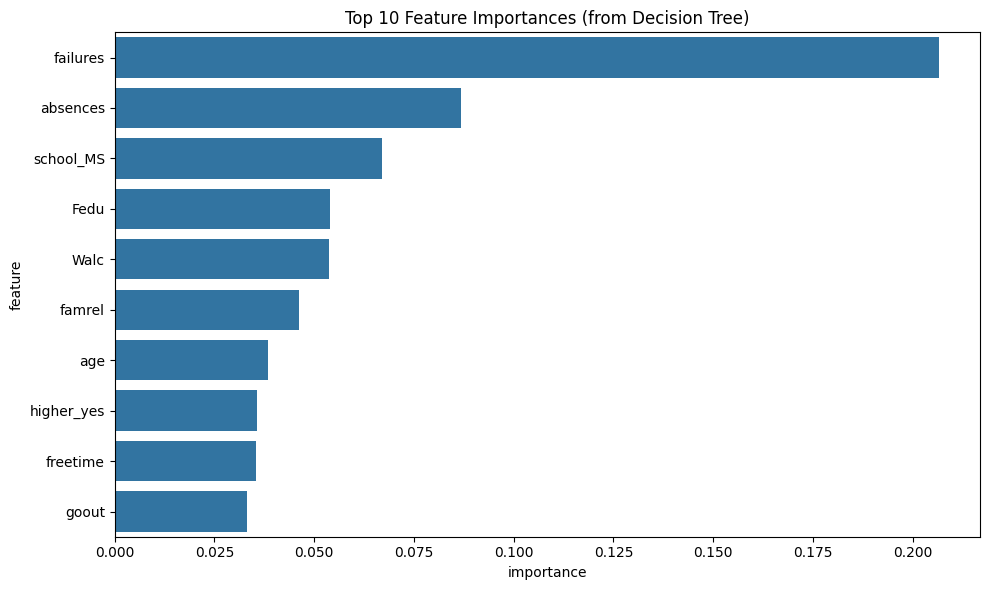

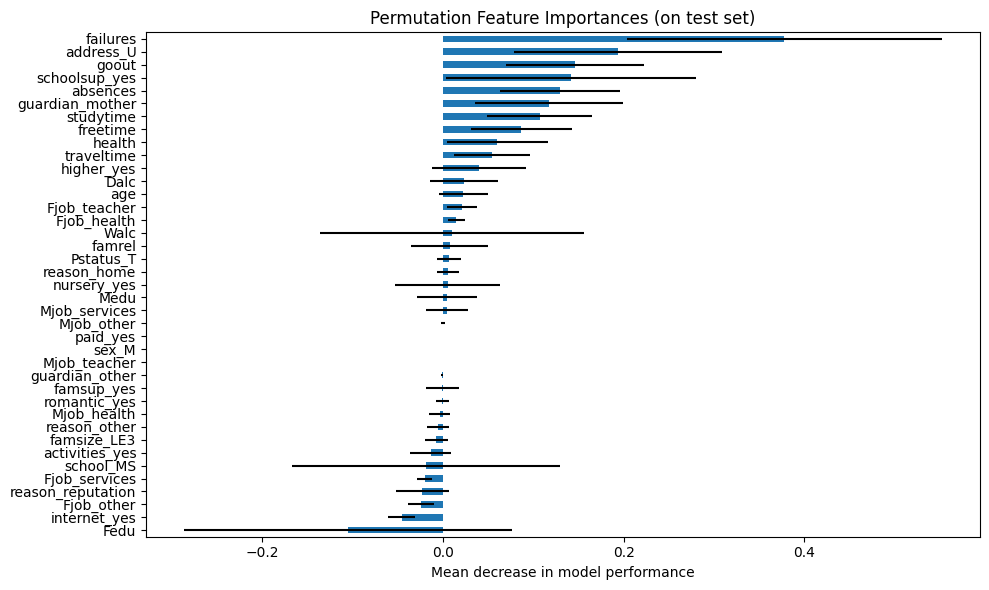

Mean Squared Error: 13.50


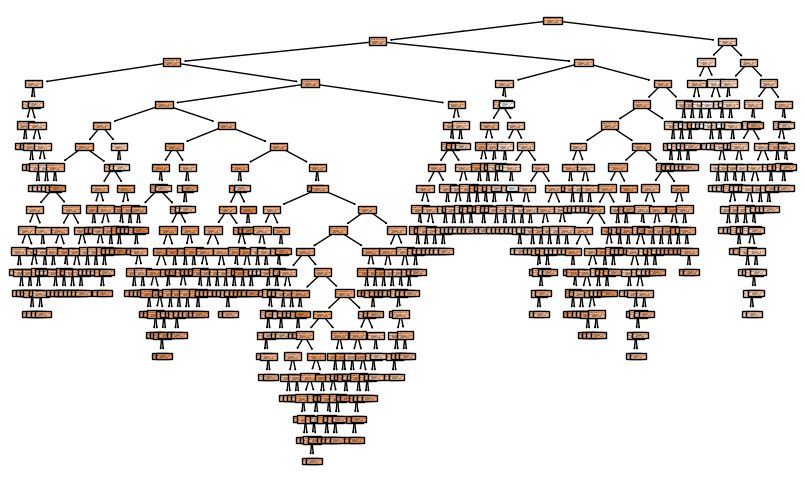

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: Step 1 - Load and Prepare the Data
# Load the two CSV files with the correct separator
df_por = pd.read_csv("student-por.csv", sep=";")
df_mat = pd.read_csv("student-mat.csv", sep=";")

# Rename the grade columns to avoid conflicts
df_por.rename(columns={"G1":"G1-P", "G2":"G2-P", "G3":"G3-P"}, inplace=True)
df_mat.rename(columns={"G1":"G1-M", "G2":"G2-M", "G3":"G3-M"}, inplace=True)

# Merge the two dataframes on common columns
common_cols = list(set(df_por.columns).intersection(set(df_mat.columns)))
merged_df = pd.merge(df_por, df_mat, on=common_cols, how='left')

# TODO: Step 2 - One-Hot Encode the Categorical Features
# Use pd.get_dummies to convert all categorical columns to numbers
df_onehot = pd.get_dummies(merged_df, drop_first=True)

# TODO: Step 3 - Define Features (X) and Target (y)
# Drop the target column and the redundant math grades from features
X = df_onehot.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
# Define the target variable (G3-P)
y = df_onehot['G3-P']

# TODO: 4 - Split the Data into Training and Testing Sets
# Split X and y into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TODO: Step 5 - Train a Decision Tree Regressor Model
# Initialize and train the model
feature_names = [f"feature {i}" for i in range(X.shape[1])]
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# TODO: Step 6 - Get and Visualize Feature Importance

# Get the feature importances from the trained model
importances = model.feature_importances_
# Create a DataFrame to hold features and their importance scores
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
# Sort the DataFrame to see the most important features first
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(10)
# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Top 10 Feature Importances (from Decision Tree)')
plt.tight_layout()
plt.show()

# Corrected code for Permutation Importance
# NOTE: This method is generally more reliable than the built-in feature_importances_
# because it measures the decrease in a model's performance when a single feature's
# values are randomly shuffled.

# Calculate permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

# Create a Series of the mean importance scores
sorted_idx = result.importances_mean.argsort()
df_onehot_importances = pd.Series(result.importances_mean[sorted_idx], index=X_test.columns[sorted_idx])

# Plot the permutation importances
fig, ax = plt.subplots(figsize=(10, 6))
df_onehot_importances.plot.barh(xerr=result.importances_std[sorted_idx], ax=ax)
ax.set_title("Permutation Feature Importances (on test set)")
ax.set_xlabel("Mean decrease in model performance")
fig.tight_layout()
plt.show()
# make predictions on the testing data
y_pred = model.predict(X_test)
# calculate the mean squared error on the testing data
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
# plot the decision tree
plt.figure(figsize=(10,6))
plot_tree(model, filled=True, feature_names=X.columns)
plt.show()

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 300}
Mean RMSE from Cross-Validation: 2.78
Standard Deviation of RMSE: 0.68
Final Test MSE: 7.89


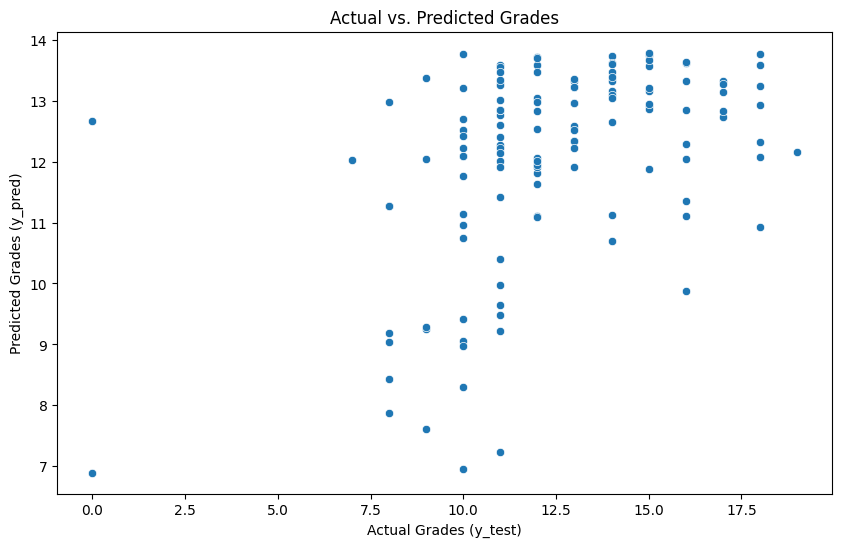

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: Step 1 - Load and Prepare the Data
# Load the two CSV files with the correct separator
df_por = pd.read_csv("student-por.csv", sep=";")
df_mat = pd.read_csv("student-mat.csv", sep=";")

# Rename the grade columns to avoid conflicts
df_por.rename(columns={"G1":"G1-P", "G2":"G2-P", "G3":"G3-P"}, inplace=True)
df_mat.rename(columns={"G1":"G1-M", "G2":"G2-M", "G3":"G3-M"}, inplace=True)

# Merge the two dataframes on common columns
common_cols = list(set(df_por.columns).intersection(set(df_mat.columns)))
merged_df = pd.merge(df_por, df_mat, on=common_cols, how='left')

# TODO: Step 2 - One-Hot Encode the Categorical Features
# Use pd.get_dummies to convert all categorical columns to numbers
df_onehot = pd.get_dummies(merged_df, drop_first=True)

# TODO: Step 3 - Define Features (X) and Target (y)
# Drop the target column and the redundant math grades from features
X = df_onehot.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
# Define the target variable (G3-P)
y = df_onehot['G3-P']

# TODO: 4 - Split the Data into Training and Testing Sets
# Split X and y into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---
### New Step 5 - Use Grid Search and Random Forest
# TODO: Define the model
model = RandomForestRegressor(random_state=42)

# TODO: Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [5, 10, 15],          # Maximum depth of the trees
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
}

# TODO: Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# TODO: Fit the grid search to the data to find the best model
grid_search.fit(X_train, y_train)

# TODO: Get the best model and print the best parameters
best_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# ---
### New Step 6 - Evaluate the Best Model using Cross-Validation
# TODO: Perform 5-fold cross-validation
scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')

# The scores are negative MSE, so we take the absolute value and mean
rmse_scores = np.sqrt(-scores)
print(f"Mean RMSE from Cross-Validation: {rmse_scores.mean():.2f}")
print(f"Standard Deviation of RMSE: {rmse_scores.std():.2f}")

# ---
### New Step 7 - Make Predictions and Final Evaluation
# TODO: Make predictions on the testing set with the best model
y_pred = best_model.predict(X_test)
# TODO: Calculate and print the final MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Final Test MSE: {mse:.2f}")

# TODO: Plot actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs. Predicted Grades')
plt.xlabel('Actual Grades (y_test)')
plt.ylabel('Predicted Grades (y_pred)')
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 519, number of used features: 30
[LightGBM] [Info] Start training from score 11.793834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

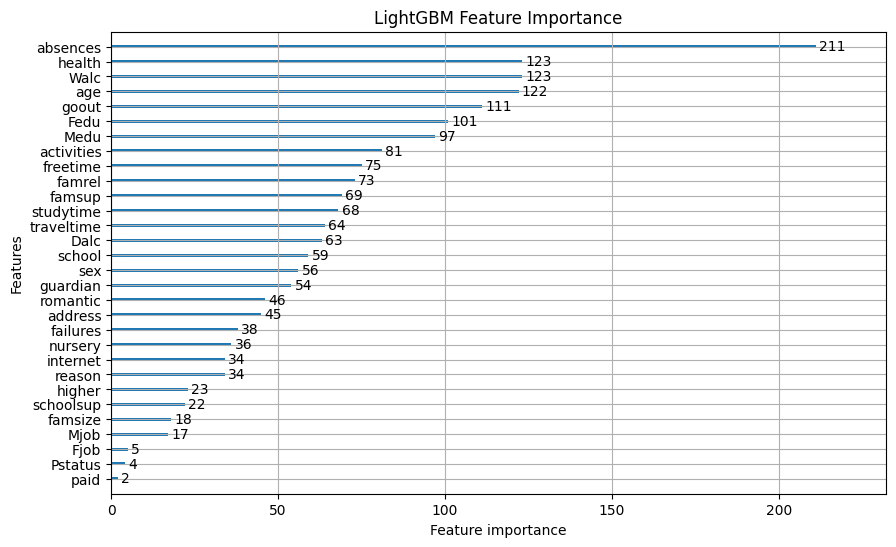

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: Step 1 - Load and Prepare the Data
# Load the two CSV files with the correct separator
df_por = pd.read_csv("student-por.csv", sep=";")
df_mat = pd.read_csv("student-mat.csv", sep=";")

# Rename the grade columns to avoid conflicts
df_por.rename(columns={"G1":"G1-P", "G2":"G2-P", "G3":"G3-P"}, inplace=True)
df_mat.rename(columns={"G1":"G1-M", "G2":"G2-M", "G3":"G3-M"}, inplace=True)

# Merge the two dataframes on common columns
common_cols = list(set(df_por.columns).intersection(set(df_mat.columns)))
merged_df = pd.merge(df_por, df_mat, on=common_cols, how='left')

# TODO: Step 2 - Identify the Categorical Features
# Get the list of categorical columns and convert them to the 'category' dtype
categorical_cols = merged_df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    merged_df[col] = merged_df[col].astype('category')

# TODO: Step 3 - Define Features (X) and Target (y)
# Drop the target column and the redundant math grades from features
X = merged_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
# Define the target variable (G3-P)
y = merged_df['G3-P']

# TODO: 4 - Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TODO: Step 5 - Train the LightGBM Model
# Initialize and train the model, passing the categorical features directly
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train, categorical_feature=categorical_cols)

# TODO: Step 6 - Make Predictions and Final Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Final Test MSE for LightGBM: {mse:.2f}")

# TODO: Step 7 - Plot Feature Importance
lgb.plot_importance(model, figsize=(10, 6), title='LightGBM Feature Importance')
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00
Final Test MSE for CatBoost: 7.94


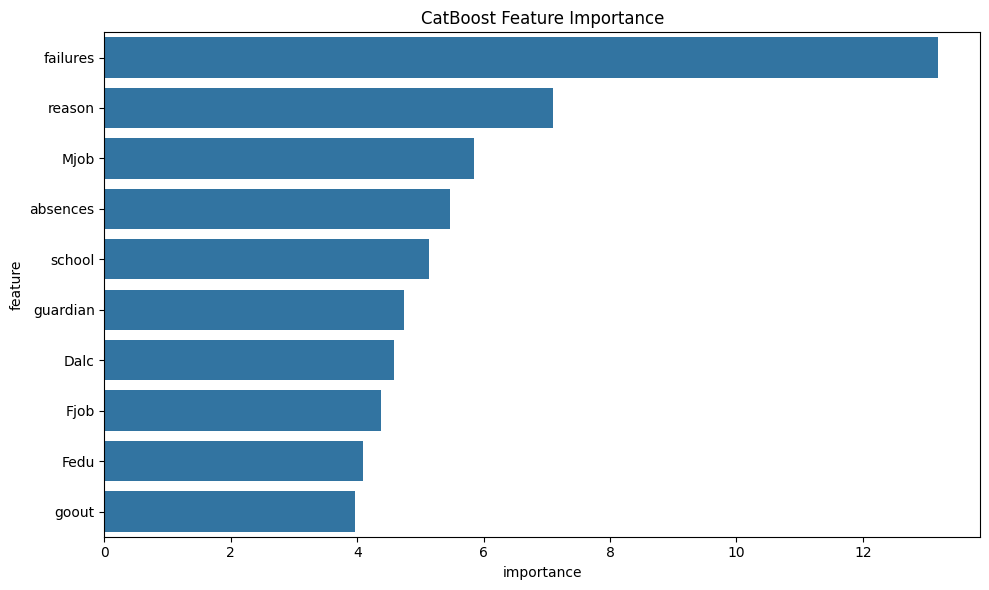

In [ ]:
!pip install catboost
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: Step 1 - Load and Prepare the Data
# (Use the same code from the previous steps to load and merge dataframes)
df_por = pd.read_csv("student-por.csv", sep=";")
df_mat = pd.read_csv("student-mat.csv", sep=";")

df_por.rename(columns={"G1":"G1-P", "G2":"G2-P", "G3":"G3-P"}, inplace=True)
df_mat.rename(columns={"G1":"G1-M", "G2":"G2-M", "G3":"G3-M"}, inplace=True)

common_cols = list(set(df_por.columns).intersection(set(df_mat.columns)))
merged_df = pd.merge(df_por, df_mat, on=common_cols, how='left')


# TODO: Step 2 - Identify the Categorical Features
# CatBoost can handle categorical features directly, just like LightGBM
# We just need to get the list of column names that are categorical
categorical_cols = merged_df.select_dtypes(include=['object']).columns.tolist()

# TODO: Step 3 - Define Features (X) and Target (y)
X = merged_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = merged_df['G3-P']

# TODO: 4 - Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TODO: Step 5 - Train the CatBoost Model
# Initialize and train the model, passing the categorical features directly
model = CatBoostRegressor(random_state=42, verbose=0)
model.fit(X_train, y_train, cat_features=categorical_cols)

# TODO: Step 6 - Make Predictions and Final Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Final Test MSE for CatBoost: {mse:.2f}")

# TODO: Step 7 - Plot Feature Importance
feature_importances = model.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
!pip install pytorch-tabnet
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pytorch_tabnet.tab_model import TabNetRegressor

# TODO: Step 1 - Load and Prepare the Data
# (Use the same code from the previous steps to load and merge dataframes)
df_por = pd.read_csv("student-por.csv", sep=";")
df_mat = pd.read_csv("student-mat.csv", sep=";")
df_por.rename(columns={"G1":"G1-P", "G2":"G2-P", "G3":"G3-P"}, inplace=True)
df_mat.rename(columns={"G1":"G1-M", "G2":"G2-M", "G3":"G3-M"}, inplace=True)
common_cols = list(set(df_por.columns).intersection(set(df_mat.columns)))
merged_df = pd.merge(df_por, df_mat, on=common_cols, how='left')


# TODO: Step 2 - Preprocess Categorical Features for TabNet
# TabNet requires categorical features to be encoded as integers
categorical_cols = merged_df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    merged_df[col] = LabelEncoder().fit_transform(merged_df[col])

# TODO: Step 3 - Define Features (X) and Target (y)
X = merged_df.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = merged_df['G3-P']

# TODO: 4 - Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the indices of the categorical features
categorical_feature_indices = [X.columns.get_loc(col) for col in categorical_cols]

# TODO: Step 5 - Train the TabNet Model
# Initialize and train the model
model = TabNetRegressor(verbose=0)
model.fit(
    X_train.values, y_train.values.reshape(-1, 1),
    eval_set=[(X_test.values, y_test.values.reshape(-1, 1))],
    eval_metric=['rmse'],
    # Specify the indices of the categorical features
    # This tells TabNet which features need to be treated as categorical
    categorical_feature_indices=categorical_feature_indices
)

# TODO: Step 6 - Make Predictions and Final Evaluation
y_pred = model.predict(X_test.values)
mse = mean_squared_error(y_test, y_pred)
print(f"Final Test MSE for TabNet: {mse:.2f}")

# TODO: Step 7 - Plot Feature Importance
feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('TabNet Feature Importance')
plt.tight_layout()
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.7 MB/s eta 0:00:00


TypeError: TabModel.fit() got an unexpected keyword argument 'categorical_feature_indices'

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 300}
Final Test MSE: 7.89


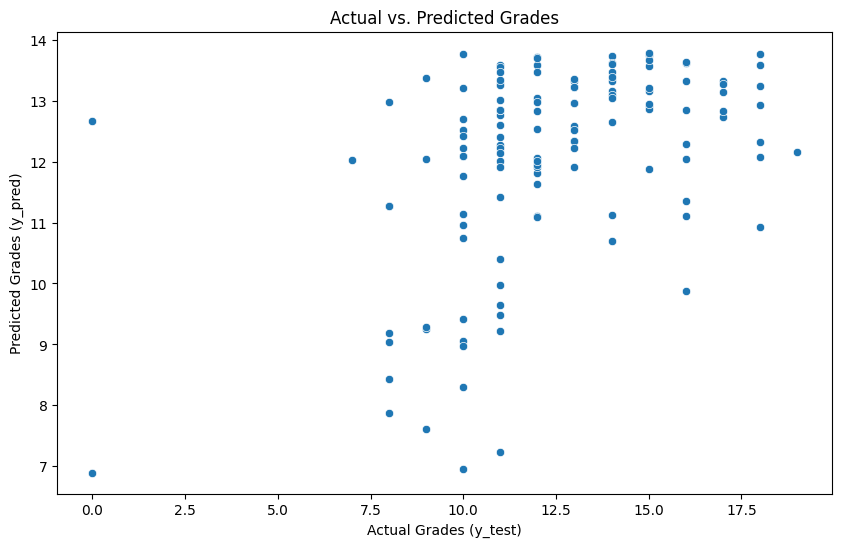

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: Step 1 - Load and Prepare the Data
# (The code for this step is correct from your last turn, you can copy it here)
df_por = pd.read_csv("student-por.csv", sep=";")
df_mat = pd.read_csv("student-mat.csv", sep=";")
df_por.rename(columns={"G1":"G1-P", "G2":"G2-P", "G3":"G3-P"}, inplace=True)
df_mat.rename(columns={"G1":"G1-M", "G2":"G2-M", "G3":"G3-M"}, inplace=True)
common_cols = list(set(df_por.columns).intersection(set(df_mat.columns)))
merged_df = pd.merge(df_por, df_mat, on=common_cols, how='left')

# TODO: Step 2 - One-Hot Encode the Categorical Features
df_onehot = pd.get_dummies(merged_df, drop_first=True)

# TODO: Step 3 - Define Features (X) and Target (y)
X = df_onehot.drop(['G1-P','G2-P','G3-P', 'G1-M', 'G2-M', 'G3-M'], axis=1)
y = df_onehot['G3-P']

# TODO: 4 - Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---
### New Step 5 - Use Grid Search and Random Forest
# TODO: Define the model
model = RandomForestRegressor(random_state=42)

# TODO: Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [5, 10, 15],          # Maximum depth of the trees
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
}

# TODO: Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# TODO: Fit the grid search to the data to find the best model
grid_search.fit(X_train, y_train)

# TODO: Get the best model and print the best parameters
best_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# ---
### New Step 6 - Evaluate the Best Model
# TODO: Make predictions on the testing set with the best model
y_pred = best_model.predict(X_test)
# TODO: Calculate and print the final MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Final Test MSE: {mse:.2f}")

# TODO: Plot actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs. Predicted Grades')
plt.xlabel('Actual Grades (y_test)')
plt.ylabel('Predicted Grades (y_pred)')
plt.show()

In [ ]:
# Select only the numerical columns from the merged_df
numerical_df = merged_df.select_dtypes(include=np.number)
print(numerical_df)

     school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  ...  \
0         0    0   18        1        0        0     4     4     0     4  ...   
1         0    0   17        1        0        1     1     1     0     2  ...   
2         0    0   15        1        1        1     1     1     0     2  ...   
3         0    0   15        1        0        1     4     2     1     3  ...   
4         0    0   16        1        0        1     3     3     2     2  ...   
..      ...  ...  ...      ...      ...      ...   ...   ...   ...   ...  ...   
644       1    0   19        0        0        1     2     3     3     2  ...   
645       1    0   18        1        1        1     3     1     4     3  ...   
646       1    0   18        1        0        1     1     1     2     2  ...   
647       1    1   17        1        1        1     3     1     3     3  ...   
648       1    1   18        0        1        1     3     2     3     2  ...   

     Dalc  Walc  health  ab

In [ ]:
"""
# Get the feature importances from the trained model
importances = model.feature_importances_
# Create a DataFrame to hold features and their importance scores
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
# Sort the DataFrame to see the most important features first
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(10)
# Plot the top 10 most important features
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Top 10 Feature Importances for G3-P')
plt.tight_layout()
plt.show()

#########################################
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
df_onehot_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
df_onehot_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
"""

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: Step 1 - Load and Prepare the Data
# Load the two CSV files
df_por = pd.read_csv("/content/student-mat.csv")
df_mat = pd.read_csv("/content/student-por.csv")

# Rename the grade columns to avoid conflicts
df_por.rename({'G1':'G1P'})
df_por.rename({'G2':'G2P'})
df_por.rename({'G3':'G3P'})
df_mat.rename({'G1':'G1M'})
df_mat.rename({'G2':'G2M'})
df_mat.rename({'G3':'G3M'})

# Merge the two dataframes on common columns
cols_df1 = set(df_por.columns)
cols_df2 = set(df_mat.columns)

common_cols = list(cols_df1.intersection(cols_df2))

merged_df = pd.merge(df_por, df_mat, on=common_cols, how='left')

# TODO: Step 2 - One-Hot Encode the Categorical Features
# Use pd.get_dummies to convert all categorical columns to numbers
df_onehot = pd.get_dummies(merged_df)

# TODO: Step 3 - Define Features (X) and Target (y)
# Drop the target columns (G3-P) and any other unnecessary columns from the dataframe
X = df_onehot.drop('G3P',axis=1)
# Define the target variable (G3-P)
y = df_onehot['G3P']

# TODO: Step 4 - Split the Data into Training and Testing Sets
# Split X and y into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.8,random_state=42)

# TODO: Step 5 - Train a Decision Tree Regressor Model
# Initialize and train the model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train,y_train)

# TODO: Step 6 - Get and Visualize Feature Importance
# Get the feature importances from the trained model
importances = model.feature_importances_
# Create a DataFrame to hold features and their importance scores
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
# Sort the DataFrame to see the most important features first
feature_importance_df = feature_importance_df.sort_values(by=feature_importance_df['feature'])
# Plot the top 10 most important features
sns.barplot(x='feature',y='importance')
plt.title('Top 10 Feature Importances')
plt.show()

KeyError: "['G3P'] not found in axis"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import OneHotEncoder

df1 = pd.read_csv("/content/student-por.csv", sep=";")
df2 = pd.read_csv("/content/student-mat.csv", sep=";")
df1.rename(columns={"G1":"G1-P"},inplace=True)
df1.rename(columns={"G2":"G2-P"},inplace=True)
df1.rename(columns={"G3":"G3-P"},inplace=True)
df2.rename(columns={"G1":"G1-M"},inplace=True)
df2.rename(columns={"G2":"G2-M"},inplace=True)
df2.rename(columns={"G3":"G3-M"},inplace=True)

cols_df1 = set(df1.columns)
cols_df2 = set(df2.columns)

common_cols = list(cols_df1.intersection(cols_df2))

merged_df = pd.merge(df1, df2, on=common_cols, how='left')

merged_df.to_csv("merged_data.csv", index=False)

#df_onehot = pd.get_dummies(merged_df)
#selected_cols = ['school', 'sex', 'address', 'famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','romantic','internet']
#merged_df = pd.merge(df_por,df_mat,on=selected_cols,how='left')

#subset_df = merged_df[selected_cols]
#cat_encoder = OneHotEncoder()
#cat_1hot = cat_encoder.fit_transform(subset_df)
#sns.scatterplot(x="age", y="G1-M", data=merged_df)
#merged_df.info()
#sns.histplot(df1.age)
#selected_cols = ['age', 'studytime', 'G3-P', 'G3-M']
#subset_df = merged_df[selected_cols]

sns.pairplot(subset_df)
#plt.show()

#print(df1.age.value_counts())
#plt.hist(df1.age)
#plt.show()
#display(df_onehot)
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                649 non-null    int64  
 1   Medu               649 non-null    int64  
 2   Fedu               649 non-null    int64  
 3   traveltime         649 non-null    int64  
 4   studytime          649 non-null    int64  
 5   failures           649 non-null    int64  
 6   famrel             649 non-null    int64  
 7   freetime           649 non-null    int64  
 8   goout              649 non-null    int64  
 9   Dalc               649 non-null    int64  
 10  Walc               649 non-null    int64  
 11  health             649 non-null    int64  
 12  absences           649 non-null    int64  
 13  G1-P               649 non-null    int64  
 14  G2-P               649 non-null    int64  
 15  G3-P               649 non-null    int64  
 16  G1-M               39 non-